In [1]:
import nltk
import pandas as pd
import numpy as np
import re
import string
import tensorflow as tf
from nltk.corpus import reuters, stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.utils import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
import json

In [2]:
# Download NLTK resources
nltk.download('reuters')
nltk.download('stopwords')

class UnifiedTokenizer:
    def __init__(self, stop_words, min_length=4, use_stemming=False):
        self.stop_words = stop_words
        self.min_length = min_length
        self.use_stemming = use_stemming
        self.stemmer = PorterStemmer() if use_stemming else None

    def tokenize(self, text):
        text = text.lower()  # Lowercase
        text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)  # Remove punctuation
        text = re.sub(r'\d+', '', text)  # Remove numbers
        tokens = text.split()  # Split into tokens
        tokens = [
            self.stemmer.stem(word) if self.use_stemming else word
            for word in tokens
            if word not in self.stop_words and len(word) >= self.min_length
        ]
        return tokens

class ReutersPreprocessor:
    def __init__(self, tokenizer, max_features=10000, max_sequence_length=500):
        self.tokenizer = tokenizer
        self.max_features = max_features
        self.max_sequence_length = max_sequence_length
        self.vocabulary = {}

    def _build_vocabulary(self, texts):
        word_counts = {}
        for tokens in texts:
            for token in tokens:
                word_counts[token] = word_counts.get(token, 0) + 1
        sorted_vocab = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        self.vocabulary = {word: idx + 1 for idx, (word, _) in enumerate(sorted_vocab[:self.max_features])}
        print(f"Vocabulary size: {len(self.vocabulary)}")

    def preprocess(self):
        documents = reuters.fileids()
        texts = [reuters.raw(doc_id) for doc_id in documents]
        labels = [reuters.categories(doc_id) for doc_id in documents]

        data = pd.DataFrame({'document_id': documents, 'text': texts, 'labels': labels})
        multi_label_data = data[data['labels'].apply(len) > 1]
        print(f"Number of multi-label articles: {len(multi_label_data)}")

        multi_label_data.loc[:, 'tokens'] = multi_label_data['text'].apply(self.tokenizer.tokenize)
        self._build_vocabulary(multi_label_data['tokens'])

        sequences = multi_label_data['tokens'].apply(lambda x: [self.vocabulary.get(token, 0) for token in x])
        X = pad_sequences(sequences.tolist(), maxlen=self.max_sequence_length, padding='post')

        mlb = MultiLabelBinarizer()
        y = mlb.fit_transform(multi_label_data['labels'])

        # Save tokenized texts, vocabulary, and labels
        with open("tokenized_texts.json", "w") as f:
            json.dump(multi_label_data['tokens'].tolist(), f)
        np.save("X.npy", X)
        np.save("y.npy", y)
        np.save("vocabulary.npy", self.vocabulary)
        np.save("class_labels.npy", mlb.classes_)

        print("Preprocessing complete. Data saved.")
        return X, y, self.vocabulary, mlb.classes_

# Initialize tokenizer and preprocessor
if __name__ == "__main__":
    stop_words = set(stopwords.words('english')) | {"reuters", "news"}
    tokenizer = UnifiedTokenizer(stop_words=stop_words, min_length=4, use_stemming=True)
    preprocessor = ReutersPreprocessor(tokenizer=tokenizer)
    X, y, vocabulary, class_labels = preprocessor.preprocess()

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Colin\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Colin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of multi-label articles: 1628
Vocabulary size: 7729
Preprocessing complete. Data saved.


C:\Users\Colin\AppData\Local\Temp\ipykernel_12764\3198827015.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_label_data.loc[:, 'tokens'] = multi_label_data['text'].apply(self.tokenizer.tokenize)


In [3]:
# Reload tokenized texts
with open("tokenized_texts.json", "r") as f:
    tokenized_texts = json.load(f)

# Reload original labels
original_labels = np.load("y.npy", allow_pickle=True)

# Define domain-specific keywords
domain_keywords = {
    # Agriculture-related categories
    "agriculture": [
        "wheat", "corn", "grain", "soybean", "crop", "harvest", "farming", "rice", "barley",
        "sorghum", "cotton", "plantation", "livestock", "oilseed"
    ],
    
    # Energy-related categories
    "energy": [
        "oil", "gas", "fuel", "crude", "barrel", "bpd", "petroleum", "energy", "prices", 
        "production", "reserves"
    ],
    
    # Finance-related categories
    "finance": [
        "market", "stock", "shares", "investment", "economy", "profit", "trade", "money",
        "currency", "rates"
    ],
    
    # Commodities and metals
    "commodities": [
        "gold", "silver", "copper", "tin", "aluminium", "zinc", "platinum", "nickel", 
        "palladium", "strategic-metal"
    ],
    
    # Trade-related categories
    "trade": [
        "exports", "imports", "tariff", "agreement", "deficit", "surplus", "shipment", 
        "commerce", "international", "global"
    ],
    
    # Other categories
    "livestock": ["beef", "pork", "cattle", "hog", "meat", "slaughter"],
    "retail": ["retail", "sales", "growth", "consumer", "earnings", "income"],
    "environment": ["climate", "carbon", "sustainability", "pollution", "green", "renewable"],
}

# Add domain-specific labels
def add_domain_labels(tokenized_texts, domain_keywords):
    updated_labels = []
    for tokens in tokenized_texts:
        labels = []
        for label, keywords in domain_keywords.items():
            if any(keyword in tokens for keyword in keywords):
                labels.append(label)
        updated_labels.append(labels)
    return updated_labels

updated_labels = add_domain_labels(tokenized_texts, domain_keywords)
print("Domain-specific labels added.")

Domain-specific labels added.


In [4]:
# Combine original and domain-specific labels
combined_labels = [
    list(set(orig_labels + new_labels))  # Combine and remove duplicates
    for orig_labels, new_labels in zip(original_labels.tolist(), updated_labels)
]

# Save combined labels as JSON
with open("combined_labels.json", "w") as f:
    json.dump(combined_labels, f)

print("Combined labels saved as JSON.")

Combined labels saved as JSON.


In [5]:
# Reload combined labels
with open("combined_labels.json", "r") as f:
    combined_labels = json.load(f)

print(f"Loaded {len(combined_labels)} combined labels.")

Loaded 1628 combined labels.


In [6]:
# Load tokenized texts
with open("tokenized_texts.json", "r") as file:
    tokenized_texts = json.load(file)

# Load original labels
original_labels = np.load("y.npy", allow_pickle=True)

# Load combined labels
with open("combined_labels.json", "r") as file:
    combined_labels = json.load(file)

# Display a few examples
for i, (tokens, orig_labels, combined) in enumerate(zip(tokenized_texts[:5], original_labels[:5], combined_labels[:5])):
    print(f"Text {i + 1} Tokens: {tokens[:10]}...")  # Show first 10 tokens for brevity
    print(f"Original Labels: {orig_labels}")
    print(f"Combined Labels: {combined}\n")

Text 1 Tokens: ['japan', 'revis', 'long', 'term', 'energi', 'demand', 'downward', 'ministri', 'intern', 'trade']...
Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Combined Labels: [0, 1, 'finance']

Text 2 Tokens: ['thai', 'trade', 'deficit', 'widen', 'first', 'quarter', 'thailand', 'trade', 'deficit', 'widen']...
Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 0 0 0 0 0]
Combined Labels: [0, 1, 'trade', 'finance', 'retail', 'agriculture']

Text 3 Tokens: ['indonesia', 'see', 'price', 'rise', 'sharpli', 'indonesia', 'expect', 'crude', 'palm', 'price']...
Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 

In [7]:
# Count articles with more than one label
multi_label_count = sum(len(labels) > 1 for labels in combined_labels)

# Print the result
print(f"Number of articles with more than one label: {multi_label_count}")

Number of articles with more than one label: 1628


In [8]:
for i in range(10):  # Check first 10 articles
    print(f"Original Labels: {original_labels[i]}")
    print(f"Combined Labels: {combined_labels[i]}")
    print()

Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Combined Labels: [0, 1, 'finance']

Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 0 0 0 0 0]
Combined Labels: [0, 1, 'trade', 'finance', 'retail', 'agriculture']

Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Combined Labels: [0, 1, 'finance', 'energy', 'agriculture']

Original Labels: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Combined Labels: [0, 1, 'finance', 'energy']


In [9]:
augmented_count = sum(len(combined) > len(orig) for orig, combined in zip(original_labels, combined_labels))
print(f"Number of articles with augmented labels: {augmented_count}")

Number of articles with augmented labels: 0


In [10]:
# Test domain matching
for tokens in tokenized_texts[:10]:
    print(f"Tokens: {tokens[:10]}")
    for label, keywords in domain_keywords.items():
        matching_keywords = [keyword for keyword in keywords if keyword in tokens]
        if matching_keywords:
            print(f"Matched keywords for label '{label}': {matching_keywords}")
    print()

Tokens: ['japan', 'revis', 'long', 'term', 'energi', 'demand', 'downward', 'ministri', 'intern', 'trade']
Matched keywords for label 'finance': ['trade']

Tokens: ['thai', 'trade', 'deficit', 'widen', 'first', 'quarter', 'thailand', 'trade', 'deficit', 'widen']
Matched keywords for label 'agriculture': ['rice']
Matched keywords for label 'finance': ['trade']
Matched keywords for label 'trade': ['deficit']
Matched keywords for label 'retail': ['growth']

Tokens: ['indonesia', 'see', 'price', 'rise', 'sharpli', 'indonesia', 'expect', 'crude', 'palm', 'price']
Matched keywords for label 'agriculture': ['crop']
Matched keywords for label 'energy': ['crude']
Matched keywords for label 'finance': ['market']

Tokens: ['indonesian', 'commod', 'exchang', 'expand', 'indonesian', 'commod', 'exchang', 'like', 'start', 'trade']
Matched keywords for label 'energy': ['crude']
Matched keywords for label 'finance': ['market', 'trade']

Tokens: ['lanka', 'get', 'usda', 'approv', 'wheat', 'price', 'food'

In [11]:
combined_labels = [
    list(set(orig_labels + new_labels))  # Combine original and domain-specific labels, remove duplicates
    for orig_labels, new_labels in zip(original_labels.tolist(), updated_labels)
]

In [12]:
num_augmented_multi_label_articles = sum(len(labels) > 1 for labels in combined_labels)
print(f"Number of articles with more than one label after augmentation: {num_augmented_multi_label_articles}")

Number of articles with more than one label after augmentation: 1628


In [13]:
for i, (tokens, orig_labels, updated, combined) in enumerate(zip(tokenized_texts[:5], original_labels[:5], updated_labels[:5], combined_labels[:5])):
    print(f"Text {i + 1} Tokens: {tokens[:10]}...")
    print(f"Original Labels: {orig_labels}")
    print(f"Domain-Specific Labels: {updated}")
    print(f"Combined Labels: {combined}\n")

Text 1 Tokens: ['japan', 'revis', 'long', 'term', 'energi', 'demand', 'downward', 'ministri', 'intern', 'trade']...
Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Domain-Specific Labels: ['finance']
Combined Labels: [0, 1, 'finance']

Text 2 Tokens: ['thai', 'trade', 'deficit', 'widen', 'first', 'quarter', 'thailand', 'trade', 'deficit', 'widen']...
Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 0 0 0 0 0]
Domain-Specific Labels: ['agriculture', 'finance', 'trade', 'retail']
Combined Labels: [0, 1, 'trade', 'finance', 'retail', 'agriculture']

Text 3 Tokens: ['indonesia', 'see', 'price', 'rise', 'sharpli', 'indonesia', 'expect', 'crude', 'palm', 'price']...
Original Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0

### Maybe this is getting too complicated. going to take it back to a simple model we can experiment on.

In [14]:
# Download required NLTK data
nltk.download('reuters')
nltk.download('stopwords')

# Define domain-specific keywords
domain_keywords = {
    "agriculture": [
        "wheat", "corn", "grain", "soybean", "crop", "harvest", "farming", "rice", "barley",
        "sorghum", "cotton", "plantation", "livestock", "oilseed", "palm-oil", "veg-oil",
        "sugar", "rubber"
    ],
    "energy": [
        "oil", "gas", "fuel", "crude", "barrel", "bpd", "petroleum", "energy", "prices",
        "production", "reserves", "nat-gas", "electricity"
    ],
    "finance": [
        "market", "stock", "shares", "investment", "economy", "profit", "trade", "money",
        "currency", "rates", "bonds", "treasury", "deficit"
    ],
    "commodities": [
        "gold", "silver", "copper", "tin", "aluminium", "zinc", "platinum", "nickel",
        "palladium", "strategic-metal", "rubber", "sugar", "coffee"
    ],
    "trade": [
        "exports", "imports", "tariff", "agreement", "deficit", "surplus", "shipment",
        "commerce", "international", "global", "balance", "trade-war", "export-growth"
    ],
    "livestock": [
        "beef", "pork", "cattle", "hog", "meat", "slaughter", "dairy", "poultry"
    ],
    "retail": [
        "retail", "sales", "growth", "consumer", "earnings", "income", "e-commerce", "spending"
    ],
    "environment": [
        "climate", "carbon", "sustainability", "pollution", "green", "renewable",
        "emissions", "clean-energy", "eco-friendly"
    ],
}

# Initialize the tokenizer
class UnifiedTokenizer:
    def __init__(self, stop_words, min_length=4, use_stemming=False):
        self.stop_words = stop_words
        self.min_length = min_length
        self.use_stemming = use_stemming
        self.stemmer = PorterStemmer() if use_stemming else None

    def tokenize(self, text):
        text = text.lower()  # Lowercase
        text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)  # Remove punctuation
        text = re.sub(r'\d+', '', text)  # Remove numbers
        tokens = text.split()  # Split into tokens
        tokens = [
            self.stemmer.stem(word) if self.use_stemming else word
            for word in tokens
            if word not in self.stop_words and len(word) >= self.min_length
        ]
        return tokens

# Load and preprocess the dataset
stop_words = set(stopwords.words('english'))
tokenizer = UnifiedTokenizer(stop_words=stop_words, min_length=4, use_stemming=True)

# Load Reuters dataset
documents = reuters.fileids()
texts = [reuters.raw(doc_id) for doc_id in documents]
labels = [reuters.categories(doc_id) for doc_id in documents]

# Create DataFrame
data = pd.DataFrame({'document_id': documents, 'text': texts, 'labels': labels})
data['tokens'] = data['text'].apply(tokenizer.tokenize)

# Augment labels
def add_domain_labels(tokens, existing_labels):
    matched_labels = set(existing_labels)
    for domain, keywords in domain_keywords.items():
        if any(keyword in tokens for keyword in keywords):
            matched_labels.add(domain)
    return list(matched_labels)

# Apply label augmentation
data['augmented_labels'] = data.apply(
    lambda row: add_domain_labels(row['tokens'], row['labels']),
    axis=1
)

# Ensure at least two labels per article
data['final_labels'] = data['augmented_labels'].apply(
    lambda labels: labels if len(labels) > 1 else labels + ["additional_label"]
)

# Verify results
multi_label_count = data['final_labels'].apply(len).value_counts()
print(f"Number of articles with at least two labels: {multi_label_count[multi_label_count.index >= 2].sum()}")

# Save augmented dataset
# Save augmented labels as JSON
with open("augmented_labels.json", "w") as f:
    json.dump(data['final_labels'].tolist(), f)
print("Augmented labels saved as JSON.")

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Colin\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Colin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of articles with at least two labels: 10788
Augmented labels saved as JSON.


In [15]:
# Load augmented labels (if saved in JSON)
with open("augmented_labels.json", "r") as f:
    augmented_labels = json.load(f)

# Display a few examples
for i, (text, original_labels, final_labels) in enumerate(
    zip(data['text'][:5], data['labels'][:5], data['final_labels'][:5])
):
    print(f"Article {i + 1} Text: {text[:100]}...")  # Show the first 100 characters of the text
    print(f"Original Labels: {original_labels}")
    print(f"Augmented Labels: {final_labels}\n")

Article 1 Text: ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT
  Mounting trade friction between the
  U.S. And Ja...
Original Labels: ['trade']
Augmented Labels: ['finance', 'trade', 'livestock']

Article 2 Text: CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STOCKS
  A survey of 19 provinces and seven cities
  show...
Original Labels: ['grain']
Augmented Labels: ['grain', 'finance', 'agriculture']

Article 3 Text: JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWARDS
  The Ministry of International Trade and
  Indust...
Original Labels: ['crude', 'nat-gas']
Augmented Labels: ['crude', 'finance', 'nat-gas']

Article 4 Text: THAI TRADE DEFICIT WIDENS IN FIRST QUARTER
  Thailand's trade deficit widened to 4.5
  billion baht ...
Original Labels: ['corn', 'grain', 'rice', 'rubber', 'sugar', 'tin', 'trade']
Augmented Labels: ['grain', 'trade', 'commodities', 'corn', 'tin', 'finance', 'retail', 'rice', 'rubber', 'sugar', 'agriculture']

Article 5 Text: INDONESIA SEES CPO PRICE RISING SHARPLY
  In

In [16]:
### test model

In [17]:
# Preprocess all articles
documents = reuters.fileids()
texts = [reuters.raw(doc_id) for doc_id in documents]

# Tokenize all articles
all_tokenized_texts = [tokenizer.tokenize(text) for text in texts]

# Save the tokenized texts
with open("tokenized_texts.json", "w") as f:
    json.dump(all_tokenized_texts, f)
print(f"Tokenized all articles: {len(all_tokenized_texts)}")

Tokenized all articles: 10788


In [18]:
import json
import numpy as np

# Step 1: Reload all tokenized texts and augmented labels
with open("tokenized_texts.json", "r") as f:
    all_tokenized_texts = json.load(f)

with open("augmented_labels.json", "r") as f:
    augmented_labels = json.load(f)

# Ensure the lengths match
if len(all_tokenized_texts) != len(augmented_labels):
    raise ValueError("Mismatch: tokenized_texts and augmented_labels must have the same length!")

# Convert augmented labels to one-hot encoding
all_labels = list(set(label for labels in augmented_labels for label in labels))
label_to_index = {label: idx for idx, label in enumerate(all_labels)}

# One-hot encode the labels
encoded_labels = [
    [label_to_index[label] for label in labels] for labels in augmented_labels
]
y = np.zeros((len(encoded_labels), len(all_labels)), dtype=int)
for i, labels in enumerate(encoded_labels):
    for label in labels:
        y[i, label] = 1

# Step 2: Split tokenized texts and labels
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    all_tokenized_texts, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")

Training samples: 7551, Validation samples: 1618, Test samples: 1619


In [19]:
print(f"Length of tokenized_texts: {len(all_tokenized_texts)}")
print(f"Length of augmented_labels: {len(augmented_labels)}")

Length of tokenized_texts: 10788
Length of augmented_labels: 10788


In [20]:
import json

# Reload tokenized texts and augmented labels
with open("tokenized_texts.json", "r") as f:
    tokenized_texts = json.load(f)
with open("augmented_labels.json", "r") as f:
    augmented_labels = json.load(f)

# Verify lengths
print(f"Length of tokenized_texts: {len(tokenized_texts)}")
print(f"Length of augmented_labels: {len(augmented_labels)}")

# Check if lengths match
if len(tokenized_texts) != len(augmented_labels):
    raise ValueError("Lengths of tokenized_texts and augmented_labels do not match!")

Length of tokenized_texts: 10788
Length of augmented_labels: 10788


In [21]:
print(f"Shape of y: {y.shape}")

Shape of y: (10788, 96)


In [22]:
print(f"Example one-hot encoded labels: {y[0]}")

Example one-hot encoded labels: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


In [23]:
import json
import numpy as np
from sklearn.model_selection import train_test_split

# Step 1: Reload Data
with open("tokenized_texts.json", "r") as f:
    tokenized_texts = json.load(f)

with open("augmented_labels.json", "r") as f:
    augmented_labels = json.load(f)

# Ensure lengths match
assert len(tokenized_texts) == len(augmented_labels), "Mismatch in tokenized texts and labels!"

# Step 2: One-Hot Encode the Labels
all_labels = list(set(label for labels in augmented_labels for label in labels))
label_to_index = {label: idx for idx, label in enumerate(all_labels)}
y = np.zeros((len(augmented_labels), len(all_labels)), dtype=int)

for i, labels in enumerate(augmented_labels):
    for label in labels:
        y[i, label_to_index[label]] = 1

print(f"Shape of one-hot encoded labels: {y.shape}")

# Step 3: Train/Validation/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    tokenized_texts, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")

# Step 4: Save Data
# Save tokenized texts as JSON
with open("X_train.json", "w") as f:
    json.dump(X_train, f)
with open("X_val.json", "w") as f:
    json.dump(X_val, f)
with open("X_test.json", "w") as f:
    json.dump(X_test, f)

# Save labels as .npy files
np.save("y_train.npy", y_train)
np.save("y_val.npy", y_val)
np.save("y_test.npy", y_test)

print("Data saved successfully for multi-label classification.")

Shape of one-hot encoded labels: (10788, 96)
Training samples: 7551, Validation samples: 1618, Test samples: 1619
Data saved successfully for multi-label classification.


In [24]:
import json
import numpy as np

# Reload Data
with open("X_train.json", "r") as f:
    X_train = json.load(f)
y_train = np.load("y_train.npy")

print(f"Number of training samples: {len(X_train)}")
print(f"Shape of training labels: {y_train.shape}")

Number of training samples: 7551
Shape of training labels: (7551, 96)


### Base model, including preproc and tok

In [25]:
# Download NLTK resources
nltk.download('reuters')
nltk.download('stopwords')

# Step 1: Define tokenizer and preprocess functions
class Tokenizer:
    def __init__(self, stop_words=None):
        self.stop_words = stop_words or set(stopwords.words('english'))
    
    def tokenize(self, text):
        text = text.lower()
        text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
        text = re.sub(r"\d+", " ", text)
        tokens = text.split()
        return [word for word in tokens if word not in self.stop_words]

# Step 2: Build Vocabulary
def build_vocabulary(tokenized_texts, max_features=10000):
    word_counts = {}
    for tokens in tokenized_texts:
        for token in tokens:
            word_counts[token] = word_counts.get(token, 0) + 1
    sorted_vocab = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    return {word: idx + 1 for idx, (word, _) in enumerate(sorted_vocab[:max_features])}

# Step 3: Add domain-specific labels
domain_keywords = {
    "agriculture": ["wheat", "corn", "grain", "soybean", "crop", "harvest", "rice"],
    "energy": ["oil", "gas", "fuel", "crude", "barrel", "energy", "production"],
    "finance": ["market", "stock", "trade", "money", "investment", "economy", "profit"],
    "commodities": ["gold", "silver", "copper", "tin", "zinc", "platinum", "nickel"],
    "trade": ["exports", "imports", "tariff", "agreement", "commerce", "global"],
}

def augment_labels(tokenized_texts, original_labels):
    augmented_labels = []
    for tokens, labels in zip(tokenized_texts, original_labels):
        domain_labels = [label for label, keywords in domain_keywords.items() if any(keyword in tokens for keyword in keywords)]
        augmented_labels.append(list(set(labels + domain_labels)))
    return augmented_labels

# Step 4: Process the data
documents = reuters.fileids()
texts = [reuters.raw(doc_id) for doc_id in documents]
original_labels = [reuters.categories(doc_id) for doc_id in documents]

tokenizer = Tokenizer(stop_words=set(stopwords.words("english")) | {"reuters", "news"})
tokenized_texts = [tokenizer.tokenize(text) for text in texts]

vocabulary = build_vocabulary(tokenized_texts)
sequences = [[vocabulary.get(token, 0) for token in tokens] for tokens in tokenized_texts]

mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(original_labels)
augmented_labels = augment_labels(tokenized_texts, [mlb.classes_[np.where(row == 1)[0]].tolist() for row in binary_labels])

# Save preprocessed data
with open("tokenized_texts.json", "w") as f:
    json.dump(sequences, f)
with open("vocabulary.json", "w") as f:
    json.dump(vocabulary, f)
with open("augmented_labels.json", "w") as f:
    json.dump(augmented_labels, f)

print(f"Preprocessing complete. Articles: {len(sequences)}, Labels: {len(augmented_labels)}")

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Colin\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Colin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing complete. Articles: 10788, Labels: 10788


In [26]:
# Reload the preprocessed data
with open("tokenized_texts.json", "r") as f:
    tokenized_texts = json.load(f)
with open("augmented_labels.json", "r") as f:
    augmented_labels = json.load(f)
with open("vocabulary.json", "r") as f:
    vocabulary = json.load(f)

# Pad sequences
max_sequence_length = 500
X = pad_sequences(tokenized_texts, maxlen=max_sequence_length, padding="post")

# One-hot encode labels
all_labels = list(set(label for labels in augmented_labels for label in labels))
mlb = MultiLabelBinarizer(classes=all_labels)
y = mlb.fit_transform(augmented_labels)

# Split the data
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")

Training samples: 7551, Validation samples: 1618, Test samples: 1619


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(input_dim=len(vocabulary) + 1, output_dim=128, input_length=max_sequence_length),
    LSTM(128, return_sequences=False),
    Dense(len(all_labels), activation="sigmoid"),
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

C:\Users\Colin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 37s 295ms/step - accuracy: 0.0123 - loss: 0.2519 - val_accuracy: 0.0142 - val_loss: 0.0673
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 281ms/step - accuracy: 0.0150 - loss: 0.0673 - val_accuracy: 0.0142 - val_loss: 0.0667
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 32s 273ms/step - accuracy: 0.0971 - loss: 0.0672 - val_accuracy: 0.3677 - val_loss: 0.0666
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 32s 272ms/step - accuracy: 0.0618 - loss: 0.0669 - val_accuracy: 0.0142 - val_loss: 0.0665
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 32s 272ms/step - accuracy: 0.0127 - loss: 0.0657 - val_accuracy: 0.0142 - val_loss: 0.0665
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 32s 275ms/step - accuracy: 0.0168 - loss: 0.0667 - val_accuracy: 0.0142 - val_loss: 0.0665
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 32s 268ms/step - accuracy: 0.0516 - loss: 0.0667 - val_accuracy: 0.0142 - val_loss: 0.0665
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 32s 273ms/step - accuracy: 0.0329 - loss: 0

### Well the results are awful, but this is a model we can work with. Positive points: loss rates are stable, so model isn't likely diverging, and well, the model ran, which is better than I've been getting lately.

### GloVe embedding experiment

In [31]:
import os

glove_path = "glove.6B.100d.txt"
if os.path.exists(glove_path):
    print("GloVe file found!")
else:
    print("GloVe file not found. Ensure it is in the same directory as your notebook.")

GloVe file found!


In [32]:
import os
import numpy as np
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant

# Specify the path to your GloVe file
glove_path = "glove.6B.100d.txt"  

# Load the GloVe embeddings
def load_glove_embeddings(glove_path, embedding_dim, vocabulary):
    embeddings_index = {}
    with open(glove_path, "r", encoding="utf-8") as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    
    print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")
    
    # Create embedding matrix
    embedding_matrix = np.zeros((len(vocabulary) + 1, embedding_dim))
    for word, idx in vocabulary.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
    return embedding_matrix

# Adjust dimensions if you're using a different GloVe file
embedding_dim = 100  # Change to 50, 200, or 300 if using a different GloVe file

# Load the embedding matrix
embedding_matrix = load_glove_embeddings(glove_path, embedding_dim, vocabulary)

# Create an embedding layer with pre-trained GloVe weights
embedding_layer = Embedding(
    input_dim=len(vocabulary) + 1,  # Vocabulary size
    output_dim=embedding_dim,      # Embedding dimensions
    embeddings_initializer=Constant(embedding_matrix),
    input_length=max_sequence_length,
    trainable=False  # Freeze the embeddings for now
)

# Update the Model with GloVe embeddings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    embedding_layer,  # Use the GloVe embedding layer
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(y_train.shape[1], activation="sigmoid")  # Multi-label classification
])

# Compile the Model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Loaded 400000 word vectors from GloVe.
Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 31s 250ms/step - accuracy: 0.0674 - loss: 0.3083 - val_accuracy: 0.0142 - val_loss: 0.0670
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 30s 258ms/step - accuracy: 0.1521 - loss: 0.0690 - val_accuracy: 0.0142 - val_loss: 0.0669
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 30s 255ms/step - accuracy: 0.1113 - loss: 0.0684 - val_accuracy: 0.0142 - val_loss: 0.0664
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 29s 242ms/step - accuracy: 0.1178 - loss: 0.0689 - val_accuracy: 0.0142 - val_loss: 0.0666
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 29s 247ms/step - accuracy: 0.1133 - loss: 0.0679 - val_accuracy: 0.0142 - val_loss: 0.0666
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 30s 254ms/step - accuracy: 0.0995 - loss: 0.0681 - val_accuracy: 0.0142 - val_loss: 0.0664
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 29s 242ms/step - accuracy: 0.0865 - loss: 0.0689 - val_accuracy: 0.3677 - val_loss: 0.0664
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 29s 

### Accuracy is still low, so time to play with regularization, dropout, etc. Possibly problem with label imbalance?

Label Frequency Distribution:
grain: 531
money-fx: 408
wheat: 283
corn: 237
interest: 206
crude: 204
dlr: 169
oilseed: 162
trade: 159
ship: 142
soybean: 111
veg-oil: 94
livestock: 77
acq: 77
bop: 74
nat-gas: 69
gnp: 62
rice: 58
carcass: 57
yen: 53
barley: 51
earn: 41
palm-oil: 40
sugar: 40
meal-feed: 38
gas: 36
cotton: 35
gold: 34
sorghum: 34
rapeseed: 27
coffee: 27
cpi: 26
soy-meal: 26
soy-oil: 25
silver: 25
reserves: 24
money-supply: 23
zinc: 21
lead: 21
hog: 21
copper: 21
jobs: 18
sunseed: 16
iron-steel: 16
oat: 14
pet-chem: 13
dmk: 13
strategic-metal: 12
fuel: 12
cocoa: 12
rubber: 9
platinum: 9
heat: 9
tea: 8
alum: 8
rape-oil: 8
ipi: 8
groundnut: 7
l-cattle: 7
coconut-oil: 7
sun-oil: 7
wpi: 6
nickel: 5
retail: 5
propane: 5
coconut: 5
orange: 5
income: 5
naphtha: 5
nkr: 3
tin: 3
palmkernel: 3
copra-cake: 3
nzdlr: 3
palladium: 3
cotton-oil: 3
housing: 3
dfl: 3
lumber: 2
sun-meal: 2
lin-oil: 2
rye: 2
castor-oil: 2
groundnut-oil: 2
jet: 2
rand: 2
lei: 1
potato: 1


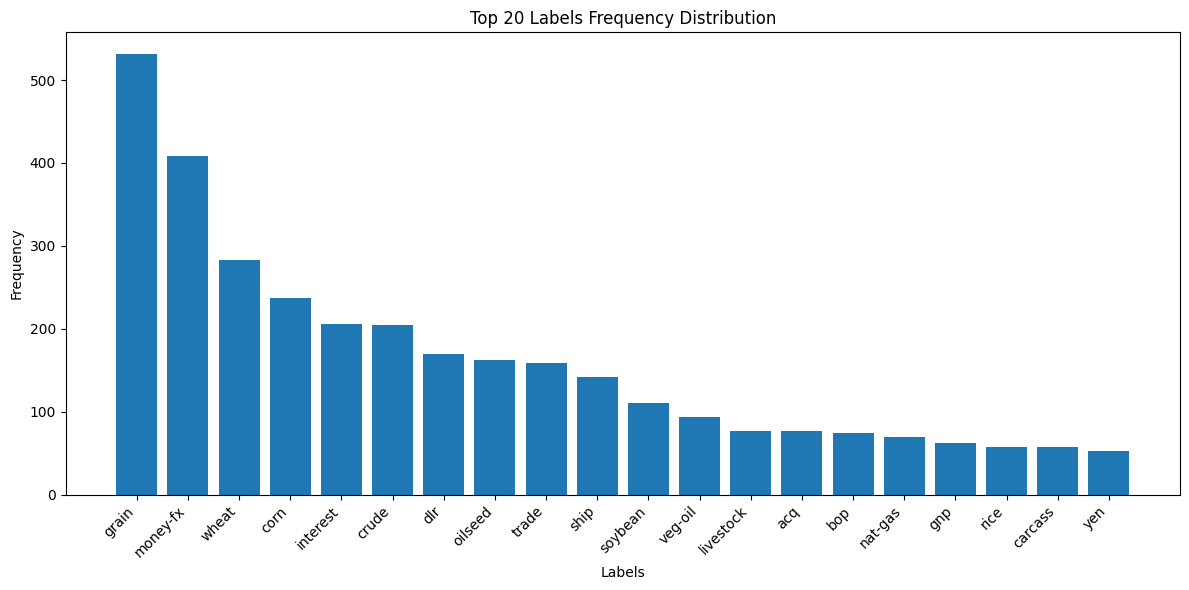

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Load the one-hot encoded labels
y = np.load("y.npy", allow_pickle=True)

# Count occurrences of each label
label_sums = y.sum(axis=0)

# Sort labels by frequency
sorted_indices = np.argsort(label_sums)[::-1]
sorted_label_sums = label_sums[sorted_indices]
sorted_labels = [class_labels[i] for i in sorted_indices]

# Display the counts
print("Label Frequency Distribution:")
for label, count in zip(sorted_labels, sorted_label_sums):
    print(f"{label}: {int(count)}")

# Plot the label frequency distribution
plt.figure(figsize=(12, 6))
plt.bar(sorted_labels[:20], sorted_label_sums[:20])  # Show the top 20 labels for clarity
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Labels Frequency Distribution")
plt.ylabel("Frequency")
plt.xlabel("Labels")
plt.tight_layout()
plt.show()

### Okay, there is definitely a long-tail imbalance for the labels. Where do we go from here? oversample the rare lables? Weighted loss?

In [34]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

# Step 1: Resampling
def resample_data(X, y, label_threshold=50):
    """
    Oversample rare labels in the dataset.
    :param X: Input features
    :param y: One-hot encoded labels
    :param label_threshold: Minimum occurrences to consider a label 'rare'
    :return: Resampled X and y
    """
    # Identify rare labels
    label_counts = np.sum(y, axis=0)
    rare_labels = np.where(label_counts < label_threshold)[0]

    # Oversample data for rare labels
    X_resampled, y_resampled = list(X), list(y)
    for i, (sample, labels) in enumerate(zip(X, y)):
        if any(labels[rare_labels]):
            # Duplicate samples with rare labels
            X_resampled.append(sample)
            y_resampled.append(labels)
    
    return np.array(X_resampled), np.array(y_resampled)

# Apply resampling
X_train_resampled, y_train_resampled = resample_data(X_train, y_train, label_threshold=50)
print(f"Training samples after resampling: {len(X_train_resampled)}")

# Step 2: Weighted Loss Function for Multi-Label
def compute_multi_label_weights(y):
    """
    Compute class weights for multi-label data.
    :param y: One-hot encoded labels
    :return: Dictionary of class weights
    """
    label_sums = np.sum(y, axis=0)  # Total occurrences per label
    total_samples = y.shape[0]
    class_weights = total_samples / (len(label_sums) * label_sums)
    return {i: weight for i, weight in enumerate(class_weights)}

# Calculate weights for multi-label data
class_weights = compute_multi_label_weights(y_train_resampled)
print(f"Class weights: {class_weights}")

# Custom weighted loss function
def weighted_binary_crossentropy(weights):
    """
    Weighted binary crossentropy loss for multi-label classification.
    :param weights: Dictionary of class weights
    :return: Weighted loss function
    """
    def loss_fn(y_true, y_pred):
        binary_crossentropy = K.binary_crossentropy(y_true, y_pred)
        weight_vector = K.constant([weights[i] for i in range(len(weights))])
        weighted_loss = binary_crossentropy * weight_vector
        return K.mean(weighted_loss, axis=-1)
    return loss_fn

# Define the weighted loss
weighted_loss = weighted_binary_crossentropy(class_weights)

# Step 3: Rebuild the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Parameters
embedding_dim = 100  # Match GloVe embeddings
max_sequence_length = 500  # Match preprocessing
num_classes = y_train.shape[1]  # Number of labels

# Create the model
model = Sequential([
    Embedding(input_dim=len(vocabulary) + 1, output_dim=embedding_dim, input_length=max_sequence_length, trainable=True),
    LSTM(128, return_sequences=False),
    Dense(num_classes, activation="sigmoid")
])

model.compile(optimizer="adam", loss=weighted_loss, metrics=["accuracy"])
model.summary()

# Step 4: Train the Model
history = model.fit(
    np.array(X_train_resampled), np.array(y_train_resampled),
    validation_data=(np.array(X_val), np.array(y_val)),
    epochs=10,  
    batch_size=64
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(np.array(X_test), np.array(y_test), verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Training samples after resampling: 8441
Class weights: {0: 1.0690222897669706, 1: 0.9977541371158393, 2: 2.244946808510638, 3: 22.449468085106382, 4: 11.224734042553191, 5: 1.8707890070921986, 6: 6.414133738601824, 7: 1.1815509518477043, 8: 0.05512453796220106, 9: 44.898936170212764, 10: 8.979787234042552, 11: 22.449468085106382, 12: 8.979787234042552, 13: 1.0690222897669706, 14: 2.244946808510638, 15: 3.207066869300912, 16: 0.03208212659536461, 17: 2.244946808510638, 18: 0.7126815265113138, 19: 1.7268821603927986, 20: 1.301418439716312, 21: 2.641113892365457, 22: 0.13362778622087132, 23: 3.4537643207855973, 24: 1.662923561859732, 25: 1.0204303675048356, 26: 0.43803840166061236, 27: 2.244946808510638, 28: 2.494385342789598, 29: 0.17369027531997203, 30: 4.0817214700193425, 31: 0.9353945035460993, 32: 0.7126815265113138, 33: 11.224734042553191, 34: 0.5683409641799084, 35: 2.641113892365457, 36: 1.8707890070921986, 37: 22.449468085106382, 38: 0.9163048198002606, 39: 6.414133738601824, 40:

C:\Users\Colin\AppData\Local\Temp\ipykernel_12764\1193131174.py:40: RuntimeWarning: divide by zero encountered in divide
  class_weights = total_samples / (len(label_sums) * label_sums)
C:\Users\Colin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 36s 259ms/step - accuracy: 0.0107 - loss: nan - val_accuracy: 0.0043 - val_loss: nan
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 256ms/step - accuracy: 0.0101 - loss: nan - val_accuracy: 0.0043 - val_loss: nan
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 255ms/step - accuracy: 0.0091 - loss: nan - val_accuracy: 0.0043 - val_loss: nan
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - accuracy: 0.0109 - loss: nan - val_accuracy: 0.0043 - val_loss: nan
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - accuracy: 0.0088 - loss: nan - val_accuracy: 0.0043 - val_loss: nan
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 35s 263ms/step - accuracy: 0.0101 - loss: nan - val_accuracy: 0.0043 - val_loss: nan
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 35s 263ms/step - accuracy: 0.0108 - loss: nan - val_accuracy: 0.0043 - val_loss: nan
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 261ms/step - accuracy: 0.0082 - loss: nan - val_accuracy: 0.0043 - val_loss: nan


In [35]:
def compute_multi_label_weights(y):
    """
    Compute class weights for multi-label data.
    Replace infinite weights with a maximum cap.
    """
    label_sums = np.sum(y, axis=0)  # Total occurrences per label
    total_samples = y.shape[0]
    with np.errstate(divide='ignore'):  # Suppress warnings for division by zero
        class_weights = total_samples / (len(label_sums) * label_sums)
    # Replace infinite weights with a high cap (e.g., max finite weight * 10)
    max_weight = np.nanmax(class_weights[np.isfinite(class_weights)])
    class_weights = np.where(np.isinf(class_weights), max_weight * 10, class_weights)
    return {i: weight for i, weight in enumerate(class_weights)}

In [36]:
# Recompute weights with the new function
class_weights = compute_multi_label_weights(y_train_resampled)
print(f"Adjusted Class weights: {class_weights}")

Adjusted Class weights: {0: 1.0690222897669706, 1: 0.9977541371158393, 2: 2.244946808510638, 3: 22.449468085106382, 4: 11.224734042553191, 5: 1.8707890070921986, 6: 6.414133738601824, 7: 1.1815509518477043, 8: 0.05512453796220106, 9: 44.898936170212764, 10: 8.979787234042552, 11: 22.449468085106382, 12: 8.979787234042552, 13: 1.0690222897669706, 14: 2.244946808510638, 15: 3.207066869300912, 16: 0.03208212659536461, 17: 2.244946808510638, 18: 0.7126815265113138, 19: 1.7268821603927986, 20: 1.301418439716312, 21: 2.641113892365457, 22: 0.13362778622087132, 23: 3.4537643207855973, 24: 1.662923561859732, 25: 1.0204303675048356, 26: 0.43803840166061236, 27: 2.244946808510638, 28: 2.494385342789598, 29: 0.17369027531997203, 30: 4.0817214700193425, 31: 0.9353945035460993, 32: 0.7126815265113138, 33: 11.224734042553191, 34: 0.5683409641799084, 35: 2.641113892365457, 36: 1.8707890070921986, 37: 22.449468085106382, 38: 0.9163048198002606, 39: 6.414133738601824, 40: 8.979787234042552, 41: 0.67517

In [37]:
def weighted_binary_crossentropy(weights):
    """
    Weighted binary crossentropy loss for multi-label classification.
    Handles invalid weights or predictions gracefully.
    """
    def loss_fn(y_true, y_pred):
        # Ensure predictions are clipped to avoid NaNs in loss computation
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        binary_crossentropy = K.binary_crossentropy(y_true, y_pred)
        weight_vector = K.constant([weights[i] for i in range(len(weights))])
        weighted_loss = binary_crossentropy * weight_vector
        return K.mean(weighted_loss, axis=-1)
    return loss_fn

# Redefine the loss
weighted_loss = weighted_binary_crossentropy(class_weights)

In [ ]:
# Train the Model
history = model.fit(
    np.array(X_train_resampled), np.array(y_train_resampled),
    validation_data=(np.array(X_val), np.array(y_val)),
    epochs=10,  # Adjust as needed
    batch_size=64
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(np.array(X_test), np.array(y_test), verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step - accuracy: 0.0099 - loss: nan - val_accuracy: 0.0043 - val_loss: nan
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 255ms/step - accuracy: 0.0102 - loss: nan - val_accuracy: 0.0043 - val_loss: nan
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step - accuracy: 0.0095 - loss: nan - val_accuracy: 0.0043 - val_loss: nan
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - accuracy: 0.0109 - loss: nan - val_accuracy: 0.0043 - val_loss: nan
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 255ms/step - accuracy: 0.0116 - loss: nan - val_accuracy: 0.0043 - val_loss: nan
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 254ms/step - accuracy: 0.0072 - loss: nan - val_accuracy: 0.0043 - val_loss: nan
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step - accuracy: 0.0094 - loss: nan - val_accuracy: 0.0043 - val_loss: nan
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - accuracy: 0.0100 - loss: nan - val_accuracy: 0.0043 - val_loss: nan


In [ ]:
optimizer = tf.keras.optimizers.Adam(clipvalue=1.0)
model.compile(optimizer=optimizer, loss=weighted_loss, metrics=["accuracy"])

NameError: name 'model' is not defined

In [ ]:
capped_class_weights = {k: min(v, 10) for k, v in class_weights.items() if not np.isinf(v)}

In [ ]:
# Validate sequences
for sequence in X_train:
    if not all(isinstance(x, int) for x in sequence):
        print(f"Invalid sequence: {sequence}")

Invalid sequence: [3566 4308   18    6    0  235   27    9   15    4    3    7    9    2
    3    2   33    2    3    2   76  120   15    4    3    4    9    2
    3    2   33   11    3    2   55  235   27    9  144    4   57  460
  168 2386  155    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
def safe_compute_class_weights(y):
    total_samples = np.sum(y)
    label_sums = np.sum(y, axis=0)
    weights = total_samples / (len(label_sums) * np.maximum(label_sums, 1))  # Avoid division by zero
    return {i: min(weight, 10) for i, weight in enumerate(weights)}

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=weighted_loss, metrics=["accuracy"])

In [ ]:
model = Sequential([
    Embedding(input_dim=len(vocabulary) + 1, output_dim=embedding_dim, input_length=max_sequence_length, trainable=True),
    LSTM(128, return_sequences=False),
    Dense(num_classes, activation="sigmoid")  # Ensure this is 'sigmoid'
])

/Users/rebeccavannostrand/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower learning rate
              loss="binary_crossentropy",  # Standard binary crossentropy loss
              metrics=["accuracy"])

In [ ]:
# Train the model
history = model.fit(
    np.array(X_train), np.array(y_train),
    validation_data=(np.array(X_val), np.array(y_val)),
    epochs=10,  # Number of epochs
    batch_size=64,  # Batch size
    verbose=1  # Print progress
)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 51s 431ms/step - accuracy: 0.0019 - loss: 0.5835 - val_accuracy: 0.0025 - val_loss: 0.1925
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 49s 418ms/step - accuracy: 0.1022 - loss: 0.1566 - val_accuracy: 0.1706 - val_loss: 0.1022
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 49s 416ms/step - accuracy: 0.1758 - loss: 0.0959 - val_accuracy: 0.1706 - val_loss: 0.0834
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 50s 423ms/step - accuracy: 0.1703 - loss: 0.0814 - val_accuracy: 0.1706 - val_loss: 0.0763
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 50s 425ms/step - accuracy: 0.1821 - loss: 0.0758 - val_accuracy: 0.1706 - val_loss: 0.0728
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 50s 421ms/step - accuracy: 0.1800 - loss: 0.0714 - val_accuracy: 0.1706 - val_loss: 0.0708
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 48s 411ms/step - accuracy: 0.1793 - loss: 0.0710 - val_accuracy: 0.1706 - val_loss: 0.0695
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 48s 408ms/step - accuracy: 0.1724 - loss: 0

### Things to try: different embedding? Bi-LSTM adding complexity? Attention, dropout, more dense layers?

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define Model Parameters
embedding_dim = 100  # Matches the GloVe embedding size
num_classes = y_train.shape[1]  # Number of labels

# Build the Model
model = Sequential([
    Embedding(input_dim=len(vocabulary) + 1, output_dim=embedding_dim, trainable=True),
    LSTM(128, return_sequences=False),
    Dense(num_classes, activation="sigmoid")
])

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Display the Model Summary
model.summary()

# Callbacks for Training
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # You can increase this if needed
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 51s 431ms/step - accuracy: 0.1391 - loss: 0.2693 - val_accuracy: 0.1706 - val_loss: 0.0671 - learning_rate: 0.0010
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 48s 409ms/step - accuracy: 0.1675 - loss: 0.0675 - val_accuracy: 0.1706 - val_loss: 0.0667 - learning_rate: 0.0010
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 49s 413ms/step - accuracy: 0.1738 - loss: 0.0674 - val_accuracy: 0.1706 - val_loss: 0.0665 - learning_rate: 0.0010
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 49s 413ms/step - accuracy: 0.1863 - loss: 0.0662 - val_accuracy: 0.1706 - val_loss: 0.0665 - learning_rate: 0.0010
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 49s 416ms/step - accuracy: 0.1918 - loss: 0.0670 - val_accuracy: 0.1706 - val_loss: 0.0666 - learning_rate: 0.0010
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 49s 418ms/step - accuracy: 0.1999 - loss: 0.0660 - val_accuracy: 0.1706 - val_loss: 0.0663 - learning_rate: 5.0000e-04
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 52s 439ms/step - accuracy:

### Add bi-LSTM, 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define Focal Loss
def focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss Function.
    :param gamma: Focusing parameter
    :param alpha: Weighting parameter
    :return: Loss function
    """
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        loss = -alpha * (1 - pt) ** gamma * K.log(pt)
        return K.mean(loss, axis=-1)
    return focal_loss_fixed

# Model Parameters
embedding_dim = 100  # Match your GloVe embedding dimension
num_classes = y_train.shape[1]  # Number of labels

# Build Model
model = Sequential([
    Embedding(input_dim=len(vocabulary) + 1, output_dim=embedding_dim, trainable=True),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="sigmoid")
])

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=["accuracy"]
)

# Model Summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)

# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # Adjust as needed
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 68s 571ms/step - accuracy: 0.1627 - loss: 0.0157 - val_accuracy: 0.4926 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 92s 781ms/step - accuracy: 0.4569 - loss: 0.0040 - val_accuracy: 0.5155 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 112s 951ms/step - accuracy: 0.5187 - loss: 0.0033 - val_accuracy: 0.5241 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 105s 887ms/step - accuracy: 0.5279 - loss: 0.0028 - val_accuracy: 0.5148 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 114s 965ms/step - accuracy: 0.5345 - loss: 0.0024 - val_accuracy: 0.5513 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 111s 939ms/step - accuracy: 0.5404 - loss: 0.0021 - val_accuracy: 0.5439 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 111s 942ms/step - accuracy

### This is considerably better. Let's look at precision, recall, f1

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predict on the test data
y_pred_prob = model.predict(X_test)  # Get probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

# Calculate precision, recall, and F1-score for each label
print("\nClassification Report:")
report = classification_report(
    y_test,
    y_pred,
    target_names=[f"Label {i}" for i in range(y_test.shape[1])],
    zero_division=0
)
print(report)

# Optionally, calculate and display metrics per label
precision = precision_score(y_test, y_pred, average=None, zero_division=0)
recall = recall_score(y_test, y_pred, average=None, zero_division=0)
f1 = f1_score(y_test, y_pred, average=None, zero_division=0)

# Combine into a readable format
metrics_summary = {
    f"Label {i}": {"Precision": p, "Recall": r, "F1-score": f}
    for i, (p, r, f) in enumerate(zip(precision, recall, f1))
}

print("\nPer-label metrics summary:")
for label, metrics in metrics_summary.items():
    print(f"{label}: {metrics}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step
Overall Test Accuracy: 0.6195

Classification Report:
              precision    recall  f1-score   support

     Label 0       0.50      0.23      0.32        13
     Label 1       0.00      0.00      0.00         2
     Label 2       0.00      0.00      0.00         6
     Label 3       0.00      0.00      0.00         3
     Label 4       0.90      0.72      0.80        25
     Label 5       0.00      0.00      0.00         0
     Label 6       0.00      0.00      0.00         1
     Label 7       0.00      0.00      0.00         1
     Label 8       0.94      0.66      0.77        44
     Label 9       0.00      0.00      0.00         2
    Label 10       0.00      0.00      0.00         1
    Label 11       0.99      0.97      0.98       567
    Label 12       0.87      0.85      0.86        93
    Label 13       0.92      0.44      0.59        25
    Label 14       0.64      0.33      0.44        21
    Label 15       0.00      0.00      0

### Wow, tons of variance here. We are still struggling with label imbalance. I'm going to research some on focal loss and maybe using BERT? 

### Starting with focal loss

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# Focal Loss Function
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        # Clip predictions to avoid log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        
        # Compute focal loss components
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)  # Probability for the true class
        ce_loss = -K.log(pt)  # Cross-entropy loss
        fl = alpha * K.pow(1 - pt, gamma) * ce_loss  # Focal loss
        
        return K.mean(fl, axis=-1)
    return loss

# Build Model
embedding_dim = 100  # Match GloVe embeddings
num_classes = y_train.shape[1]  # Number of labels

model = Sequential([
    Embedding(input_dim=len(vocabulary) + 1, output_dim=embedding_dim, trainable=True),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dense(num_classes, activation="sigmoid")
])

# Compile Model with Focal Loss
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)

model.summary()

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Analyze Metrics
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test) > 0.5  # Binary predictions
print("Overall Test Accuracy:", accuracy_score(y_test, y_pred))

report = classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(num_classes)], zero_division=0)
print("Classification Report:\n", report)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 93s 777ms/step - accuracy: 0.1956 - loss: 0.0138 - val_accuracy: 0.4493 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.4811 - loss: 0.0039 - val_accuracy: 0.5031 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.5218 - loss: 0.0032 - val_accuracy: 0.5297 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.5324 - loss: 0.0025 - val_accuracy: 0.5365 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.5582 - loss: 0.0021 - val_accuracy: 0.5488 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.5718 - loss: 0.0019 - val_accuracy: 0.5705 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.5875 - loss: 

### This is not bad, but there is room for improvement. The micro-average F1 score (0.84) indicates decent overall performance, considering the imbalanced dataset. It reflects how well the model performs across all labels by treating each label equally.

### The weighted average F1 score (0.81) considers the support of each class. This means the model performs better on labels with more samples.

### Macro Average shows we are struggling with the underrepresented classes.

### Still seeing a lot of variance among labels. we need to find some way to balance labels with high support with those with very low support.

### I experimented with using BERT but was not successful in getting it to work. Maybe someone can look into this and figure it out?

### Going to work on trying to figure out how to improve the model in other ways.

### Checking to see if the GloVe is working right

In [ ]:
import numpy as np

glove_path = "glove.6B.100d.txt"

# Load GloVe embeddings
embedding_index = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefficients

print(f"Loaded {len(embedding_index)} word vectors from GloVe.")

Loaded 400000 word vectors from GloVe.


In [ ]:

embedding_dim = 100  # Match GloVe dimension
vocabulary_size = len(vocabulary) + 1

# Initialize the embedding matrix
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, i in vocabulary.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (10001, 100)


In [ ]:
from tensorflow.keras.layers import Embedding

model = Sequential([
    Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False  # Freeze the embeddings for now
    ),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dense(num_classes, activation="sigmoid")
])

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ ?                      │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,100 (3.82 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,100 (3.82 MB)

In [ ]:
# Compile and train the model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,  # Short test run
    batch_size=64
)

# Check results
print("Training complete.")

Epoch 1/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 74s 615ms/step - accuracy: 0.1810 - loss: 0.2417 - val_accuracy: 0.3931 - val_loss: 0.0627
Epoch 2/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 90s 760ms/step - accuracy: 0.4556 - loss: 0.0600 - val_accuracy: 0.4845 - val_loss: 0.0529
Epoch 3/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 85s 721ms/step - accuracy: 0.4965 - loss: 0.0519 - val_accuracy: 0.4710 - val_loss: 0.0472
Training complete.


### Okay, GloVe seems to be working, let's try again.

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
import numpy as np

# Focal Loss Function
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        # Clip predictions to avoid log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        
        # Compute focal loss components
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)  # Probability for the true class
        ce_loss = -K.log(pt)  # Cross-entropy loss
        fl = alpha * K.pow(1 - pt, gamma) * ce_loss  # Focal loss
        
        return K.mean(fl, axis=-1)
    return loss

# Assuming `embedding_matrix` is already prepared from GloVe
embedding_dim = 100  # Match GloVe embeddings
num_classes = y_train.shape[1]  # Number of labels

# Build Model with GloVe Embeddings
model = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],  # Vocabulary size
        output_dim=embedding_matrix.shape[1],  # Embedding dimension
        weights=[embedding_matrix],  # Pre-trained embeddings
        trainable=False  # Initially freeze embeddings
    ),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dense(num_classes, activation="sigmoid")
])

# Compile Model with Focal Loss
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)

model.summary()

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Analyze Metrics
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test) > 0.5  # Binary predictions
print("Overall Test Accuracy:", accuracy_score(y_test, y_pred))

report = classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(num_classes)], zero_division=0)
print("Classification Report:\n", report)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ ?                      │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,100 (3.82 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,100 (3.82 MB)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 65s 546ms/step - accuracy: 0.1893 - loss: 0.0139 - val_accuracy: 0.4845 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 73s 619ms/step - accuracy: 0.4951 - loss: 0.0034 - val_accuracy: 0.4870 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 91s 771ms/step - accuracy: 0.5076 - loss: 0.0026 - val_accuracy: 0.5513 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 90s 759ms/step - accuracy: 0.5494 - loss: 0.0022 - val_accuracy: 0.5340 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 79s 670ms/step - accuracy: 0.5602 - loss: 0.0020 - val_accuracy: 0.5507 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 96s 816ms/step - accuracy: 0.5680 - loss: 0.0019 - val_accuracy: 0.5791 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 86s 732ms/step - accuracy: 0.5

### Micro-average F1-score: 0.88 indicates strong performance across all labels.
### Weighted-average F1-score: 0.86 shows good overall balance despite class imbalances.

### Trying making the embeddings trainable just to try something else to improve the model.

In [ ]:
# Build Model with Trainable GloVe Embeddings
model = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],  # Vocabulary size
        output_dim=embedding_matrix.shape[1],  # Embedding dimension
        weights=[embedding_matrix],  # Pre-trained embeddings
        trainable=True  # Set embeddings to trainable
    ),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dense(num_classes, activation="sigmoid")
])

# Compile Model with Focal Loss
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)

model.summary()

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Analyze Metrics
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test) > 0.5  # Binary predictions
print("Overall Test Accuracy:", accuracy_score(y_test, y_pred))

report = classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(num_classes)], zero_division=0)
print("Classification Report:\n", report)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ ?                      │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,100 (3.82 MB)

 Trainable params: 1,000,100 (3.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 79s 666ms/step - accuracy: 0.2675 - loss: 0.0122 - val_accuracy: 0.4734 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 83s 706ms/step - accuracy: 0.4985 - loss: 0.0029 - val_accuracy: 0.5000 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 83s 704ms/step - accuracy: 0.5248 - loss: 0.0024 - val_accuracy: 0.5433 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 101s 861ms/step - accuracy: 0.5585 - loss: 0.0019 - val_accuracy: 0.5674 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 104s 879ms/step - accuracy: 0.5986 - loss: 0.0016 - val_accuracy: 0.5451 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 103s 870ms/step - accuracy: 0.6129 - loss: 0.0014 - val_accuracy: 0.6248 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 106s 898ms/step - accuracy:

### Here's the comparison between the non-trainable and trainable embeddings.

#### Non-train: Best Validation Accuracy: ~61%
	•	Best Validation Loss: ~0.0011
	•	Test Accuracy: ~60.5%
	•	Micro-Average Metrics:
	•	Precision: 0.92
	•	Recall: 0.83
	•	F1-Score: 0.88
	•	Macro-Average Metrics:
	•	Precision: 0.44
	•	Recall: 0.32
	•	F1-Score: 0.36
	•	Weighted Average F1-Score: 0.86

 #### Trainable: Best Validation Accuracy: ~62.5%
	•	Best Validation Loss: ~0.0010
	•	Test Accuracy: ~58%
	•	Micro-Average Metrics:
	•	Precision: 0.94
	•	Recall: 0.88
	•	F1-Score: 0.91
	•	Macro-Average Metrics:
	•	Precision: 0.56
	•	Recall: 0.41
	•	F1-Score: 0.45
	•	Weighted Average F1-Score: 0.90

 ### Precision, Recall and F1 all improved with the trainable embeddings. The macro-averages also increased, and indicates even the low-support labels are improving. Overall acccuracy dropped slightly, but weighted F1 is up, so it might be doing better overall.


### This experiment will add some regularization and an attention mechanism,

In [ ]:
from tensorflow.keras.layers import Layer, Dropout, Dense, Embedding, LSTM, Bidirectional, Input, Activation
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l2

# Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="attention_weight",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name="attention_bias", shape=(1,), initializer="zeros", trainable=True
        )
        super(Attention, self).build(input_shape)

    def call(self, x):
        # Compute attention scores
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        # Apply scores to input
        output = x * a
        return K.sum(output, axis=1)

# Build Model
embedding_dim = embedding_matrix.shape[1]  # GloVe Embedding dimension
num_classes = y_train.shape[1]  # Number of labels

input_seq = Input(shape=(X_train.shape[1],))  # Sequence input
x = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=True
)(input_seq)
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3))(x)  # LSTM with Dropout
x = Attention()(x)  # Add Attention Layer
x = Dropout(0.5)(x)  # Dropout after Attention
x = Dense(num_classes, activation="sigmoid", kernel_regularizer=l2(0.01))(x)  # Dense with L2

model = Model(inputs=input_seq, outputs=x)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)

model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_16 (Embedding)        │ (None, 500, 100)       │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 500, 256)       │       234,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 256)            │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 94)             │        24,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,011 (4.80 MB)

 Trainable params: 1,259,011 (4.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 99s 827ms/step - accuracy: 0.0827 - loss: 0.8122 - val_accuracy: 0.1706 - val_loss: 0.0566 - learning_rate: 0.0010
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 94s 793ms/step - accuracy: 0.2244 - loss: 0.0334 - val_accuracy: 0.1706 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 96s 810ms/step - accuracy: 0.1994 - loss: 0.0112 - val_accuracy: 0.1706 - val_loss: 0.0106 - learning_rate: 0.0010
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 92s 783ms/step - accuracy: 0.2130 - loss: 0.0105 - val_accuracy: 0.1706 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 95s 806ms/step - accuracy: 0.2270 - loss: 0.0099 - val_accuracy: 0.1706 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 94s 801ms/step - accuracy: 0.2154 - loss: 0.0094 - val_accuracy: 0.1706 - val_loss: 0.0091 - learning_rate: 0.0010
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 99s 841ms/step - accuracy: 0.2

### Fine tuning, reducing drop out, learning rate. If this doesn't work, I'll try without the attention and see if that is good. 

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Define the Attention Mechanism
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        query, key, value = inputs, inputs, inputs
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        attention_output = tf.matmul(attention_scores, value)
        return tf.reduce_mean(attention_output, axis=1)

# Build the Model
embedding_dim = 100  # Match GloVe embeddings
input_dim = embedding_matrix.shape[0]  # Vocabulary size
output_dim = embedding_matrix.shape[1]  # Embedding dimension
num_classes = y_train.shape[1]  # Number of labels

input_layer = Input(shape=(500,), name="input_layer")
x = Embedding(input_dim=input_dim, 
              output_dim=output_dim, 
              weights=[embedding_matrix], 
              trainable=True, 
              name="embedding")(input_layer)
x = Bidirectional(LSTM(128, return_sequences=True, 
                       kernel_regularizer=l2(0.01)), 
                  name="bidirectional")(x)
x = Attention(name="attention")(x)
x = Dropout(0.2, name="dropout")(x)  # Reduced dropout rate
output_layer = Dense(num_classes, activation="sigmoid", name="dense")(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the Model
optimizer = Adam(learning_rate=0.0001)  # Lowered learning rate
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",  # binary crossentropy for multi-label classification
    metrics=["accuracy"]
)

model.summary()

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 500, 100)       │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 500, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 94)             │        24,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,258,754 (4.80 MB)

 Trainable params: 1,258,754 (4.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 109s 918ms/step - accuracy: 0.1726 - loss: 3.5894 - val_accuracy: 0.1706 - val_loss: 2.4401 - learning_rate: 1.0000e-04
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 115s 973ms/step - accuracy: 0.2417 - loss: 2.2304 - val_accuracy: 0.1706 - val_loss: 1.6774 - learning_rate: 1.0000e-04
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 112s 953ms/step - accuracy: 0.2383 - loss: 1.5365 - val_accuracy: 0.1706 - val_loss: 1.1551 - learning_rate: 1.0000e-04
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 113s 957ms/step - accuracy: 0.2583 - loss: 1.0581 - val_accuracy: 0.1706 - val_loss: 0.7899 - learning_rate: 1.0000e-04
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 105s 893ms/step - accuracy: 0.2799 - loss: 0.7225 - val_accuracy: 0.3968 - val_loss: 0.5382 - learning_rate: 1.0000e-04
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 113s 960ms/step - accuracy: 0.3368 - loss: 0.4970 - val_accuracy: 0.4493 - val_loss: 0.3794 - learning_rate: 1.0000e-04
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Define the Attention Mechanism
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        query, key, value = inputs, inputs, inputs
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        attention_output = tf.matmul(attention_scores, value)
        return tf.reduce_mean(attention_output, axis=1)

# Build the Model
embedding_dim = 100  # Match GloVe embeddings
input_dim = embedding_matrix.shape[0]  # Vocabulary size
output_dim = embedding_matrix.shape[1]  # Embedding dimension
num_classes = y_train.shape[1]  # Number of labels

input_layer = Input(shape=(500,), name="input_layer")
x = Embedding(input_dim=input_dim, 
              output_dim=output_dim, 
              weights=[embedding_matrix], 
              trainable=True, 
              name="embedding")(input_layer)
x = Bidirectional(LSTM(128, return_sequences=True, 
                       kernel_regularizer=l2(0.01)), 
                  name="bidirectional")(x)
x = Attention(name="attention")(x)
x = Dropout(0.2, name="dropout")(x)  # Reduced dropout rate
output_layer = Dense(num_classes, activation="sigmoid", name="dense")(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the Model
optimizer = Adam(learning_rate=0.0001)  # Lowered learning rate
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",  # binary crossentropy for multi-label classification
    metrics=["accuracy"]
)

model.summary()

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predictions and Metric Evaluation
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Precision, Recall, and F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="micro", zero_division=0)
print(f"Micro-average Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Detailed Classification Report
report = classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(num_classes)], zero_division=0)
print("Classification Report:\n", report)

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 500, 100)       │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 500, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 94)             │        24,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,258,754 (4.80 MB)

 Trainable params: 1,258,754 (4.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 88s 740ms/step - accuracy: 0.0304 - loss: 3.5966 - val_accuracy: 0.1706 - val_loss: 2.4497 - learning_rate: 1.0000e-04
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 83s 701ms/step - accuracy: 0.2351 - loss: 2.2389 - val_accuracy: 0.1706 - val_loss: 1.6814 - learning_rate: 1.0000e-04
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 83s 703ms/step - accuracy: 0.2262 - loss: 1.5413 - val_accuracy: 0.1706 - val_loss: 1.1570 - learning_rate: 1.0000e-04
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 83s 705ms/step - accuracy: 0.2435 - loss: 1.0587 - val_accuracy: 0.4067 - val_loss: 0.7901 - learning_rate: 1.0000e-04
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 82s 698ms/step - accuracy: 0.2990 - loss: 0.7226 - val_accuracy: 0.4258 - val_loss: 0.5380 - learning_rate: 1.0000e-04
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 89s 755ms/step - accuracy: 0.3531 - loss: 0.4911 - val_accuracy: 0.1706 - val_loss: 0.3667 - learning_rate: 1.0000e-04
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 89s 75

### Model is struggling. I'm going to try more fine-tuning, but if this is still off, I'm going to try without attention and go another way.

In [ ]:
# Updated Model with Fine-Tuning
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Attention Layer (if still using attention)
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        query, key, value = inputs, inputs, inputs
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        attention_output = tf.matmul(attention_scores, value)
        return tf.reduce_mean(attention_output, axis=1)

# Build the Model
embedding_dim = 100
input_dim = embedding_matrix.shape[0]
output_dim = embedding_matrix.shape[1]
num_classes = y_train.shape[1]

input_layer = Input(shape=(500,), name="input_layer")
x = Embedding(input_dim=input_dim, output_dim=output_dim, weights=[embedding_matrix], trainable=True)(input_layer)
x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)))(x)  # Reduced LSTM units
x = Attention()(x)  # Keep or remove?
x = Dropout(0.1)(x)  # Reduced dropout
output_layer = Dense(num_classes, activation="sigmoid")(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the Model
optimizer = Adam(learning_rate=5e-5)  # Further reduced learning rate
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,  # Allow for more training time
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Metrics for Evaluation
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

y_pred = model.predict(X_test) > 0.5  # Convert probabilities to binary predictions
print("Overall Test Accuracy:", accuracy_score(y_test, y_pred))

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="micro")
print(f"Micro-average Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Epoch 1/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - accuracy: 0.0066 - loss: 3.4143 - val_accuracy: 6.1805e-04 - val_loss: 2.9222 - learning_rate: 5.0000e-05
Epoch 2/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 52s 438ms/step - accuracy: 0.0027 - loss: 2.7837 - val_accuracy: 6.1805e-04 - val_loss: 2.4120 - learning_rate: 5.0000e-05
Epoch 3/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 49s 413ms/step - accuracy: 0.0901 - loss: 2.3179 - val_accuracy: 0.1706 - val_loss: 2.0525 - learning_rate: 5.0000e-05
Epoch 4/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 49s 416ms/step - accuracy: 0.2159 - loss: 1.9812 - val_accuracy: 0.1706 - val_loss: 1.7696 - learning_rate: 5.0000e-05
Epoch 5/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 50s 426ms/step - accuracy: 0.2288 - loss: 1.7101 - val_accuracy: 0.1706 - val_loss: 1.5314 - learning_rate: 5.0000e-05
Epoch 6/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 50s 427ms/step - accuracy: 0.2473 - loss: 1.4795 - val_accuracy: 0.1706 - val_loss: 1.3263 - learning_rate: 5.0000e-05
Epoch 7/25
118/118 ━━━━━━━━━━━━━━━━━━━

### I don't see a way to improve the model, after adding attention. I think the way forward is to work on class weights to address the label imbalance. Going to remove attention and see if we can get back to the accuracy and r/p/f1 levels we had and move forward from there.

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Build the Model
embedding_dim = 100
input_dim = embedding_matrix.shape[0]
output_dim = embedding_matrix.shape[1]
num_classes = y_train.shape[1]

input_layer = Input(shape=(500,), name="input_layer")
x = Embedding(input_dim=input_dim, output_dim=output_dim, weights=[embedding_matrix], trainable=True)(input_layer)
x = Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01)))(x)  # Removed attention
x = Dropout(0.2)(x)  # Stabilized dropout
output_layer = Dense(num_classes, activation="sigmoid")(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the Model
optimizer = Adam(learning_rate=1e-4)  # Conservative learning rate
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Metrics for Evaluation
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

y_pred = model.predict(X_test) > 0.5  # Convert probabilities to binary predictions
print("Overall Test Accuracy:", accuracy_score(y_test, y_pred))

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="micro")
print(f"Micro-average Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Epoch 1/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 84s 708ms/step - accuracy: 0.0245 - loss: 3.6210 - val_accuracy: 0.1706 - val_loss: 2.4333 - learning_rate: 1.0000e-04
Epoch 2/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 109s 925ms/step - accuracy: 0.2423 - loss: 2.2236 - val_accuracy: 0.1712 - val_loss: 1.6695 - learning_rate: 1.0000e-04
Epoch 3/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 111s 938ms/step - accuracy: 0.2760 - loss: 1.5288 - val_accuracy: 0.3028 - val_loss: 1.1489 - learning_rate: 1.0000e-04
Epoch 4/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 111s 940ms/step - accuracy: 0.2972 - loss: 1.0518 - val_accuracy: 0.4481 - val_loss: 0.7848 - learning_rate: 1.0000e-04
Epoch 5/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 109s 924ms/step - accuracy: 0.3651 - loss: 0.7183 - val_accuracy: 0.4512 - val_loss: 0.5327 - learning_rate: 1.0000e-04
Epoch 6/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 111s 944ms/step - accuracy: 0.3985 - loss: 0.4874 - val_accuracy: 0.4635 - val_loss: 0.3614 - learning_rate: 1.0000e-04
Epoch 7/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 1

### well, this is kind of discouraging. Our earlier model was doing much better than any of these. I'm reverting back to before we added attention to see if we can get improvement from here.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score

# Define Focal Loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)  # Prevent division by zero
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)  # Calculate pt
        loss = -alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss, axis=-1)
    return focal_loss_fixed

# Build Model
model = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],  # Vocabulary size
        output_dim=embedding_matrix.shape[1],  # Embedding dimension
        weights=[embedding_matrix],  # Pre-trained GloVe embeddings
        trainable=True  # Set embeddings to trainable
    ),
    Bidirectional(LSTM(128, return_sequences=False)),  # Bidirectional LSTM
    Dense(num_classes, activation="sigmoid")  # Sigmoid for multi-label classification
])

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)

# Summarize Model
model.summary()

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Analyze Metrics
y_pred = model.predict(X_test) > 0.5  # Binary predictions
print("Overall Test Accuracy:", accuracy_score(y_test, y_pred))

report = classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(num_classes)], zero_division=0)
print("Classification Report:\n", report)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ ?                      │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,100 (3.82 MB)

 Trainable params: 1,000,100 (3.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 74s 621ms/step - accuracy: 0.2538 - loss: 0.0125 - val_accuracy: 0.4512 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 91s 771ms/step - accuracy: 0.4954 - loss: 0.0029 - val_accuracy: 0.5328 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 109s 926ms/step - accuracy: 0.5386 - loss: 0.0022 - val_accuracy: 0.5680 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 108s 920ms/step - accuracy: 0.5693 - loss: 0.0018 - val_accuracy: 0.5890 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 107s 906ms/step - accuracy: 0.5934 - loss: 0.0014 - val_accuracy: 0.5890 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 104s 881ms/step - accuracy: 0.5889 - loss: 0.0012 - val_accuracy: 0.5457 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0

### I'm kind of at a loss of where to go from here. I'm going to adjust class weights to try and deal with the label imbalance. Because this is a multi-label project, I think we need to adjust the loss function to apply class weights.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Initialize class weights
class_weights = {}

# Iterate over each label
for i in range(num_classes):
    y_label = y_train[:, i]  # Extract column corresponding to the label
    unique_values = np.unique(y_label)
    
    if len(unique_values) == 1:  # Check if only one unique value exists
        # If all values are the same (e.g., all 0s or all 1s), set weight to 1
        class_weights[i] = [1.0, 1.0]
    else:
        # Compute class weights normally
        class_weights[i] = compute_class_weight(
            class_weight='balanced',
            classes=unique_values,
            y=y_label
        )

# Convert to a dictionary of weights for each class
class_weights_dict = {i: class_weights[i][1] if len(class_weights[i]) > 1 else 1.0 for i in range(num_classes)}
print("Class Weights (Positive):", class_weights_dict)

Class Weights (Positive): {0: 45.48795180722892, 1: 188.775, 2: 343.22727272727275, 3: 157.3125, 4: 30.204, 5: 1887.75, 6: 539.3571428571429, 7: 377.55, 8: 18.598522167487683, 9: 269.67857142857144, 10: 755.1, 11: 1.3527409530634182, 12: 9.534090909090908, 13: 43.901162790697676, 14: 53.93571428571428, 15: 179.78571428571428, 16: 755.1, 17: 471.9375, 18: 85.80681818181819, 19: 188.775, 20: 188.775, 21: 29.728346456692915, 22: 1.0, 23: 1887.75, 24: 188.775, 25: 125.85, 26: 77.05102040816327, 27: 198.71052631578948, 28: 1887.75, 29: 7.432086614173229, 30: 47.79113924050633, 31: 12.298045602605864, 32: 74.02941176470588, 33: 188.775, 34: 1258.5, 35: 77.05102040816327, 36: 314.625, 37: 51.71917808219178, 38: 157.3125, 39: 1887.75, 40: 43.39655172413793, 41: 99.35526315789474, 42: 1.158839779005525, 43: 9.053956834532373, 44: 39.742105263157896, 45: 139.83333333333334, 46: 755.1, 47: 1258.5, 48: 3.0870809484873263, 49: 1258.5, 50: 1887.75, 51: 1887.75, 52: 2.7740631888317413, 53: 539.357142

In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score

# Define Weighted Binary Cross-Entropy Loss
def weighted_binary_crossentropy(class_weights):
    """
    Custom loss function for weighted binary crossentropy.
    Args:
    - class_weights (Tensor): Tensor of weights for each class.
    """
    def loss_fn(y_true, y_pred):
        # Compute binary cross-entropy
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        # Apply weights to positive class
        weights = tf.reduce_sum(class_weights * y_true, axis=-1)
        return tf.reduce_mean(bce * weights)
    
    return loss_fn

# Convert class_weights_dict to a TensorFlow constant
class_weights_tensor = tf.constant(
    [class_weights_dict[i] for i in range(len(class_weights_dict))], dtype=tf.float32
)

# Create the weighted loss function
weighted_loss = weighted_binary_crossentropy(class_weights_tensor)

# Compile the Model with the New Loss Function
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=weighted_loss,
    metrics=["accuracy"]
)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predictions for Classification Report
y_pred = model.predict(X_test) > 0.5  # Binary predictions

# Overall Accuracy
overall_accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Test Accuracy: {overall_accuracy}")

# Classification Report
report = classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(num_classes)], zero_division=0)
print("Classification Report:\n", report)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 67s 562ms/step - accuracy: 0.5786 - loss: 2.8320 - val_accuracy: 0.5260 - val_loss: 3.0138 - learning_rate: 0.0010
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 84s 715ms/step - accuracy: 0.5511 - loss: 3.0065 - val_accuracy: 0.5556 - val_loss: 2.9061 - learning_rate: 0.0010
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 84s 716ms/step - accuracy: 0.5807 - loss: 2.2168 - val_accuracy: 0.5198 - val_loss: 3.0321 - learning_rate: 0.0010
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 85s 718ms/step - accuracy: 0.5888 - loss: 1.7927 - val_accuracy: 0.5674 - val_loss: 2.7897 - learning_rate: 0.0010
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 84s 713ms/step - accuracy: 0.5891 - loss: 1.5131 - val_accuracy: 0.5179 - val_loss: 2.7371 - learning_rate: 0.0010
51/51 - 5s - 98ms/step - accuracy: 0.5627 - loss: 3.5215
Test Loss: 3.5214879512786865, Test Accuracy: 0.5626929998397827
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step
Overall Test Accuracy: 0.644224830142063
Classification Report:

### Training loss seems to decrease steadily, which is expected, but validation loss fluctuates, indicating potential overfitting or difficulty in generalizing. Precision is strong, but recall is lagging behind (problem identifying all positive labels.)Still having problems with label imbalance.

### keeping the current weights for the loss factor, adding oversampling, tuning learning rate, add dropout.

In [ ]:
from sklearn.utils import resample
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Combine the features and labels into one dataset for easier handling
data_combined = [(X_train[i], y_train[i]) for i in range(len(y_train))]

# Oversample based on class weights
oversampled_data = []

for i in range(num_classes):
    # Extract samples belonging to class `i`
    class_data = [data for data in data_combined if data[1][i] == 1]
    if len(class_data) > 0:
        # Use only the positive class weight for oversampling
        positive_weight = class_weights[i][1] if isinstance(class_weights[i], np.ndarray) else class_weights[i]
        
        # Oversample the current class
        oversampled_class = resample(
            class_data,
            replace=True,
            n_samples=int(max(positive_weight * len(class_data), len(class_data))),
            random_state=42
        )
        oversampled_data.extend(oversampled_class)

# Shuffle the oversampled dataset
np.random.shuffle(oversampled_data)

# Split back into features and labels
X_train_oversampled, y_train_oversampled = zip(*oversampled_data)
X_train_oversampled = np.array(X_train_oversampled)
y_train_oversampled = np.array(y_train_oversampled)

# Build Model
model = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],  # Vocabulary size
        output_dim=embedding_matrix.shape[1],  # Embedding dimension
        weights=[embedding_matrix],  # Pre-trained embeddings
        trainable=True  # Set embeddings to trainable
    ),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dense(num_classes, activation="sigmoid")
])

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train Model
history = model.fit(
    X_train_oversampled, y_train_oversampled,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Analyze Metrics
y_pred = model.predict(X_test) > 0.5  # Binary predictions
overall_accuracy = accuracy_score(y_test, y_pred)
print("Overall Test Accuracy:", overall_accuracy)

report = classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(num_classes)], zero_division=0)
print("Classification Report:\n", report)

Epoch 1/20
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 3744s 690ms/step - accuracy: 0.1943 - loss: 0.0565 - val_accuracy: 0.5618 - val_loss: 0.0216 - learning_rate: 0.0010
Epoch 2/20
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 3736s 688ms/step - accuracy: 0.2797 - loss: 7.8256e-04 - val_accuracy: 0.5241 - val_loss: 0.0254 - learning_rate: 0.0010
Epoch 3/20
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 3747s 690ms/step - accuracy: 0.2804 - loss: 3.1554e-04 - val_accuracy: 0.4969 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 4/20
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 3720s 686ms/step - accuracy: 0.2827 - loss: 2.7268e-04 - val_accuracy: 0.5408 - val_loss: 0.0292 - learning_rate: 0.0010
Epoch 5/20
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 3765s 694ms/step - accuracy: 0.2950 - loss: 1.9226e-04 - val_accuracy: 0.5470 - val_loss: 0.0306 - learning_rate: 5.0000e-04
Epoch 6/20
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 3780s 696ms/step - accuracy: 0.2845 - loss: 1.8851e-04 - val_accuracy: 0.5321 - val_loss: 0.0322 - learning_rate: 5.0000e-04
51/51 - 6s - 110ms

### That took forever to run with the increased sampling. But here's the analysis: Precision: 91%
	•	Recall: 86%
	•	F1-score: 88%
	•	These metrics indicate strong overall performance at the instance level, meaning the model is correctly identifying the presence of labels across the dataset.

 ### Weighted precision, recall, and F1-score (all ~87%) show the model handles class imbalances reasonably well.

 ### There’s some improvement in precision, recall, and F1-score for a few rare labels (e.g., Labels 2, 19, 27). The oversampling and weighting are likely helping here.

 ### A validation accuracy of ~56% and a test accuracy of ~59% show moderate improvements compared to earlier iterations.

 ### A macro F1-score of ~50% indicates the model is still struggling to generalize across all labels, especially the less frequent ones.


### trying to use focal loss again

In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score

# Define the focal loss function
def focal_loss(gamma=2., alpha=0.25):
    """
    Focal loss for multi-label classification.

    Args:
        gamma: Focusing parameter to reduce the impact of well-classified examples.
        alpha: Balancing parameter to give weight to minority classes.

    Returns:
        A callable loss function.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to avoid log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        # Compute focal loss components
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * (1 - pt) ** gamma * tf.math.log(pt)
        
        # Return mean loss over all classes
        return tf.reduce_mean(loss, axis=-1)
    
    return focal_loss_fixed

# Compile the model with focal loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)

# Define Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predict and analyze metrics
y_pred = model.predict(X_test) > 0.5  # Binary predictions
print("Overall Test Accuracy:", accuracy_score(y_test, y_pred))

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(y_test.shape[1])], zero_division=0)
print("Classification Report:\n", report)

# Optional: Save the model
model.save('focal_loss_model.h5')
print("Model saved as 'focal_loss_model.h5'")

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 67s 565ms/step - accuracy: 0.6311 - loss: 2.9453e-04 - val_accuracy: 0.5742 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 84s 713ms/step - accuracy: 0.6192 - loss: 1.3767e-04 - val_accuracy: 0.5927 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 84s 711ms/step - accuracy: 0.6270 - loss: 1.3576e-04 - val_accuracy: 0.5698 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 97s 819ms/step - accuracy: 0.6076 - loss: 7.9471e-05 - val_accuracy: 0.5705 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 95s 806ms/step - accuracy: 0.6008 - loss: 6.0001e-05 - val_accuracy: 0.5464 - val_loss: 0.0038 - learning_rate: 5.0000e-04
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 88s 747ms/step - accuracy: 0.5946 - loss: 4.3531e-05 - val_accuracy: 0.5464 - val_loss: 0.0038 - learning_rate: 5.0000e-04
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━

Overall Test Accuracy: 0.7282273008029648
Classification Report:
               precision    recall  f1-score   support

     Label 0       0.54      0.54      0.54        13
     Label 1       1.00      0.50      0.67         2
     Label 2       1.00      0.67      0.80         6
     Label 3       1.00      0.67      0.80         3
     Label 4       0.92      0.88      0.90        25
     Label 5       0.00      0.00      0.00         0
     Label 6       0.50      1.00      0.67         1
     Label 7       0.00      0.00      0.00         1
     Label 8       0.84      0.84      0.84        44
     Label 9       1.00      1.00      1.00         2
    Label 10       1.00      1.00      1.00         1
    Label 11       0.97      0.96      0.97       567
    Label 12       0.96      0.84      0.90        93
    Label 13       0.82      0.72      0.77        25
    Label 14       0.78      0.67      0.72        21
    Label 15       0.50      0.25      0.33         4
    Label 16   

1.	Test Loss: 0.003776939120143652
	2.	Test Accuracy: 0.5639283657073975
	3.	Overall Test Accuracy: 0.7282273008029648
	4.	Micro-averaged Precision: 0.91
	5.	Micro-averaged Recall: 0.87
	6.	Micro-averaged F1-score: 0.89

    Overall, the class balancing is better, but some labels just have such low support I'm not sure we can fix it. We can see the struggle in the macro-averaged stats. But the micro-averaged stats show the model is performing well overall, especially on the labels with high support.

Classes with higher support (e.g., Label 11, Label 42, and Label 57) consistently exhibit excellent precision, recall, and F1-scores.
	•	Rare classes (e.g., Label 5, Label 7, and Label 24) either show no performance improvement or remain unpredicted, suggesting the need for additional measures such as data augmentation or further tuning.

Doing one last try doing a hybrid of focal loss and class weights.

In [ ]:
import tensorflow as tf

# Define the Hybrid Loss Function
def hybrid_loss(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    
    # Focal Loss Component
    alpha = 0.25
    gamma = 2.0
    focal_loss = -alpha * (1 - y_pred) ** gamma * y_true * tf.math.log(y_pred)
    focal_loss = tf.reduce_sum(focal_loss, axis=-1)
    
    # Weighted Cross-Entropy Component
    class_weights_tensor = tf.constant([class_weights_dict[i] for i in range(len(class_weights_dict))], dtype=tf.float32)
    weighted_loss = tf.reduce_sum(class_weights_tensor * y_true * -tf.math.log(y_pred), axis=-1)
    
    # Hybrid Loss: Weighted Sum
    lambda_factor = 0.5  # Adjust this value for balancing
    hybrid = lambda_factor * focal_loss + (1 - lambda_factor) * weighted_loss
    
    return hybrid

# Compile the Model with Hybrid Loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=hybrid_loss,
    metrics=['accuracy']
)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
    ]
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predictions and Metrics
y_pred = model.predict(X_test) > 0.5
from sklearn.metrics import classification_report, accuracy_score
print("Overall Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(num_classes)], zero_division=0))

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 67s 559ms/step - accuracy: 0.6382 - loss: 0.2713 - val_accuracy: 0.6007 - val_loss: 15.7791 - learning_rate: 0.0010
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 86s 726ms/step - accuracy: 0.6609 - loss: 0.0015 - val_accuracy: 0.5983 - val_loss: 13.3286 - learning_rate: 0.0010
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 87s 736ms/step - accuracy: 0.6595 - loss: 9.6647e-04 - val_accuracy: 0.5977 - val_loss: 11.8023 - learning_rate: 0.0010
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 86s 733ms/step - accuracy: 0.6633 - loss: 5.2819e-04 - val_accuracy: 0.6001 - val_loss: 10.5773 - learning_rate: 0.0010
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 86s 729ms/step - accuracy: 0.6736 - loss: 3.6578e-04 - val_accuracy: 0.6082 - val_loss: 9.3051 - learning_rate: 0.0010
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 96s 817ms/step - accuracy: 0.6598 - loss: 2.7956e-04 - val_accuracy: 0.6119 - val_loss: 7.7157 - learning_rate: 0.0010
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 85s 717ms/

The hybrid did not work -- it basically assigned a positive value to every label, so recall is stellar but precision is nil. Reverting back to focal loss only.

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score

# Define Focal Loss Function
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * tf.math.pow(1. - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

# Build Model
model = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],  # Vocabulary size
        output_dim=embedding_matrix.shape[1],  # Embedding dimension
        weights=[embedding_matrix],  # Pre-trained embeddings
        trainable=True  # Set embeddings to trainable
    ),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.3),
    Dense(num_classes, activation="sigmoid")
])

# Compile Model with Focal Loss
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Analyze Metrics
y_pred = model.predict(X_test) > 0.5  # Binary predictions
print("Overall Test Accuracy:", accuracy_score(y_test, y_pred))

report = classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(num_classes)], zero_division=0)
print("Classification Report:\n", report)

# Save Model
model.save("focal_loss_only_model.h5")
print("Model saved as 'focal_loss_only_model.h5'")

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 68s 567ms/step - accuracy: 0.2001 - loss: 0.0124 - val_accuracy: 0.4697 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 90s 764ms/step - accuracy: 0.4877 - loss: 0.0033 - val_accuracy: 0.4994 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 89s 754ms/step - accuracy: 0.5215 - loss: 0.0027 - val_accuracy: 0.5284 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 87s 734ms/step - accuracy: 0.5431 - loss: 0.0023 - val_accuracy: 0.5408 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 88s 743ms/step - accuracy: 0.5622 - loss: 0.0019 - val_accuracy: 0.5661 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 86s 728ms/step - accuracy: 0.5785 - loss: 0.0016 - val_accuracy: 0.6075 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 88s 742ms/step - accuracy: 0.6

Overall Test Accuracy: 0.7930821494749846
Classification Report:
               precision    recall  f1-score   support

     Label 0       0.75      0.46      0.57        13
     Label 1       0.00      0.00      0.00         2
     Label 2       1.00      0.17      0.29         6
     Label 3       0.00      0.00      0.00         3
     Label 4       0.95      0.84      0.89        25
     Label 5       0.00      0.00      0.00         0
     Label 6       0.00      0.00      0.00         1
     Label 7       0.00      0.00      0.00         1
     Label 8       0.97      0.77      0.86        44
     Label 9       1.00      1.00      1.00         2
    Label 10       0.00      0.00      0.00         1
    Label 11       0.98      0.98      0.98       567
    Label 12       0.98      0.86      0.91        93
    Label 13       0.81      0.68      0.74        25
    Label 14       0.83      0.48      0.61        21
    Label 15       0.00      0.00      0.00         4
    Label 16   

### Is there a way to add unsupervised learning (LDA) to improve the model? Attempting to add LDA topic modeling, topics are concatenated with tokenized text features

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Create Bag of Words Representation
print("Creating Bag of Words Representation...")
vectorizer = CountVectorizer(max_features=10000)  # Limit vocabulary size
X_train_bow = vectorizer.fit_transform(X_train)  # Fit on training data
X_test_bow = vectorizer.transform(X_test)        # Transform test data

# Step 2: Generate LDA Topic Distributions
print("Generating LDA Topic Distributions...")
lda = LatentDirichletAllocation(n_components=10, random_state=42)  # Adjust `n_components` as needed
X_train_lda = lda.fit_transform(X_train_bow)
X_test_lda = lda.transform(X_test_bow)

# Step 3: Combine GloVe embeddings with LDA topic distributions
print("Combining GloVe Embeddings with LDA Topics...")
X_train_combined = np.hstack((X_train_glove, X_train_lda))
X_test_combined = np.hstack((X_test_glove, X_test_lda))

# Step 4: Build Model
print("Building Model...")
model = Sequential([
    Input(shape=(X_train_combined.shape[1],)),  # Adjust input size for combined features
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation="sigmoid")
])

# Step 5: Compile Model with Focal Loss
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * tf.math.pow(1. - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)

# Step 6: Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Step 7: Train the Model
print("Training Model...")
history = model.fit(
    X_train_combined, y_train,
    validation_data=(X_test_combined, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Step 8: Evaluate the Model
print("Evaluating Model...")
test_loss, test_accuracy = model.evaluate(X_test_combined, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Analyze Metrics
y_pred = model.predict(X_test_combined) > 0.5  # Binary predictions
print("Overall Test Accuracy:", accuracy_score(y_test, y_pred))

report = classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(num_classes)], zero_division=0)
print("Classification Report:\n", report)

# Save Model
model.save("focal_loss_with_lda_model.h5")
print("Model saved as 'focal_loss_with_lda_model.h5'")

Creating Bag of Words Representation...
Generating LDA Topic Distributions...
Combining GloVe Embeddings with LDA Topics...
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/rebeccavannostrand/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/dt/bk1f58k14m3122wwk2r1x07c0000gn/T/ipykernel_70051/1614150293.py", line 25, in <module>
    X_train_combined = np.hstack((X_train_glove, X_train_lda))
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<__array_function__ internals>", line 200, in hstack
  File "/Users/rebeccavannostrand/anaconda3/lib/python3.11/site-packages/numpy/core/shape_base.py", line 368, in hstack
  File "<__array_function__ internals>", line 200, in concatenate
ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/rebeccavannostrand/

In [ ]:
print("Shape of X_train_glove:", X_train_glove.shape)
print("Shape of X_train_lda:", X_train_lda.shape)

Shape of X_train_glove: (8630,)
Shape of X_train_lda: (8630, 10)


### this is not right. let me confirm the GloVe embeddings again.

In [ ]:
# Ensure embedding_matrix is a dictionary {word: vector}
print("Processing GloVe embeddings...")

# Generate GloVe embeddings for the training set
X_train_glove = np.array([
    np.mean(
        [embedding_matrix[word] for word in text.split() if word in embedding_matrix],
        axis=0
    ) if any(word in embedding_matrix for word in text.split()) else np.zeros(embedding_matrix.shape[1])
    for text in X_train
])

# Generate GloVe embeddings for the test set
X_test_glove = np.array([
    np.mean(
        [embedding_matrix[word] for word in text.split() if word in embedding_matrix],
        axis=0
    ) if any(word in embedding_matrix for word in text.split()) else np.zeros(embedding_matrix.shape[1])
    for text in X_test
])

# Ensure the shapes are as expected
print("Shape of X_train_glove:", X_train_glove.shape)
print("Shape of X_test_glove:", X_test_glove.shape)

Processing GloVe embeddings...


/var/folders/dt/bk1f58k14m3122wwk2r1x07c0000gn/T/ipykernel_70051/3509213032.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ) if any(word in embedding_matrix for word in text.split()) else np.zeros(embedding_matrix.shape[1])
/var/folders/dt/bk1f58k14m3122wwk2r1x07c0000gn/T/ipykernel_70051/3509213032.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ) if any(word in embedding_matrix for word in text.split()) else np.zeros(embedding_matrix.shape[1])


Shape of X_train_glove: (8630, 100)
Shape of X_test_glove: (2158, 100)


In [ ]:
# Combine GloVe embeddings with LDA topic distributions
print("Combining GloVe Embeddings with LDA Topics...")
X_train_combined = np.hstack((X_train_glove, X_train_lda))
X_test_combined = np.hstack((X_test_glove, X_test_lda))

# Ensure the combined shapes are as expected
print("Shape of X_train_combined:", X_train_combined.shape)
print("Shape of X_test_combined:", X_test_combined.shape)

Combining GloVe Embeddings with LDA Topics...
Shape of X_train_combined: (8630, 110)
Shape of X_test_combined: (2158, 110)


### GloVe embeddings are precomputed and combined with LDA, so we no longer need the embedding layer.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score

# Define Focal Loss Function
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * tf.math.pow(1. - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

# Build Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_combined.shape[1],)),  # Input layer
    Dropout(0.3),
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')  # Output layer for multi-label classification
])

# Compile Model with Focal Loss
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train Model
history = model.fit(
    X_train_combined, y_train,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test_combined, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Analyze Metrics
y_pred = model.predict(X_test_combined) > 0.5  # Binary predictions
print("Overall Test Accuracy:", accuracy_score(y_test, y_pred))

report = classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(num_classes)], zero_division=0)
print("Classification Report:\n", report)

# Save Model
model.save("glove_lda_model.h5")
print("Model saved as 'glove_lda_model.h5'")

Epoch 1/20


/Users/rebeccavannostrand/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Dimensions must be equal, but are 90 and 94 for '{{node compile_loss/focal_loss_fixed/SelectV2}} = SelectV2[T=DT_FLOAT](compile_loss/focal_loss_fixed/Equal, compile_loss/focal_loss_fixed/clip_by_value, compile_loss/focal_loss_fixed/sub)' with input shapes: [?,90], [?,94], [?,94].

In [ ]:
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of y_train: (8630, 90)
Shape of y_test: (2158, 90)


In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_combined.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(90, activation="sigmoid")  # Change 90 to match the number of classes in y_train and y_test
])

/Users/rebeccavannostrand/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)

In [ ]:
# Train, evaluate, and save the model
history = model.fit(
    X_train_combined, y_train,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_combined, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Analyze metrics
y_pred = model.predict(X_test_combined) > 0.5  # Binary predictions
print("Overall Test Accuracy:", accuracy_score(y_test, y_pred))

report = classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(90)], zero_division=0)
print("Classification Report:\n", report)

# Save the model
model.save("focal_loss_with_lda_model.h5")
print("Model saved as 'focal_loss_with_lda_model.h5'")

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1008 - loss: 0.0264 - val_accuracy: 0.5516 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.4817 - loss: 0.0034 - val_accuracy: 0.5927 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.5716 - loss: 0.0027 - val_accuracy: 0.6263 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.5971 - loss: 0.0025 - val_accuracy: 0.6327 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.6062 - loss: 0.0025 - val_accuracy: 0.6396 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.6223 - loss: 0.0023 - val_accuracy: 0.6466 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.6173 - los

Overall Test Accuracy: 0.5440222428174235
Classification Report:
               precision    recall  f1-score   support

     Label 0       0.87      0.93      0.90       469
     Label 1       0.00      0.00      0.00         7
     Label 2       0.00      0.00      0.00         6
     Label 3       0.00      0.00      0.00        20
     Label 4       0.00      0.00      0.00        15
     Label 5       0.00      0.00      0.00         2
     Label 6       0.00      0.00      0.00        17
     Label 7       0.00      0.00      0.00         0
     Label 8       0.00      0.00      0.00         0
     Label 9       0.00      0.00      0.00        28
    Label 10       0.00      0.00      0.00         9
    Label 11       0.00      0.00      0.00         0
    Label 12       0.00      0.00      0.00        53
    Label 13       0.00      0.00      0.00        11
    Label 14       0.00      0.00      0.00         0
    Label 15       0.00      0.00      0.00        20
    Label 16   

In [ ]:
# Get the top words for each topic
def print_lda_topics(lda_model, feature_names, num_top_words=10):
    for topic_idx, topic in enumerate(lda_model.components_):
        print(f"Topic #{topic_idx}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
        print()

# `lda` is your trained LDA model, `vectorizer` is your CountVectorizer
feature_names = vectorizer.get_feature_names_out()
print_lda_topics(lda, feature_names)

Topic #0:
billion, dlrs, in, mln, the, to, of, from, 1986, year

Topic #1:
the, of, to, said, and, it, in, lt, for, its

Topic #2:
the, to, of, and, said, in, that, on, for, be

Topic #3:
the, in, to, of, and, said, pct, year, from, for

Topic #4:
mln, vs, stg, profit, loss, net, tax, 1986, year, ltd

Topic #5:
the, to, of, in, bank, said, and, pct, at, rate

Topic #6:
cts, april, record, dividend, may, lt, pay, div, march, prior

Topic #7:
oil, dlrs, the, to, for, and, said, crude, prices, price

Topic #8:
tonnes, 000, mln, the, wheat, 87, in, for, corn, grain

Topic #9:
vs, 000, mln, cts, net, loss, shr, dlrs, qtr, revs



### The topics aren't that meaningful. Probably need to add some words to the stopwords dictionary. #4, 6, 7,8, 9 might be okay. #1, 2, 3 should fixed.

### Going to preprocess data again with added stopwords. Increase number of topics. This will combine the topics found through LDA with GloVe embeddings.

In [ ]:
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords

# Download stopwords
nltk.download("stopwords")

# Custom stopwords
custom_stopwords = set(stopwords.words("english"))
custom_stopwords.update({"mln", "lt", "pct", "dlrs", "vs", "000", "said", "year", "loss", "profit", "net"})

# Convert custom_stopwords to a list
custom_stopwords = list(custom_stopwords)

# Initialize the CountVectorizer with the corrected stopwords
vectorizer = CountVectorizer(
    max_features=5000,  # Limit vocabulary size
    stop_words=custom_stopwords,  # Use custom stopwords
    lowercase=True,  # Convert text to lowercase
    token_pattern=r'\b[a-zA-Z]{3,}\b'  # Ignore single/double letters or numbers
)

# Transform training and test data into Bag-of-Words representation
print("Creating Bag of Words Representation...")
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Fit LDA on the processed Bag-of-Words data
print("Generating LDA Topic Distributions...")
n_topics = 15  # Adjust number of topics for improved separation
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
X_train_lda = lda.fit_transform(X_train_bow)
X_test_lda = lda.transform(X_test_bow)

# Combine GloVe embeddings with LDA topics
print("Combining GloVe Embeddings with LDA Topics...")
X_train_combined = np.hstack((X_train_glove, X_train_lda))
X_test_combined = np.hstack((X_test_glove, X_test_lda))

print("Shape of X_train_combined:", X_train_combined.shape)
print("Shape of X_test_combined:", X_test_combined.shape)

# Inspect topics
for idx, topic in enumerate(lda.components_):
    print(f"Topic #{idx + 1}:")
    print(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rebeccavannostrand/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Creating Bag of Words Representation...
Generating LDA Topic Distributions...
Combining GloVe Embeddings with LDA Topics...
Shape of X_train_combined: (8630, 115)
Shape of X_test_combined: (2158, 115)
Topic #1:
exports export crop usda last production corn grain wheat tonnes
Topic #2:
producers brazil would price market oil opec sugar coffee prices
Topic #3:
ltd subsidiary acquisition sell group sale unit corp company inc
Topic #4:
one would interest money banks rates stg market rate bank
Topic #5:
compared march quarter december rise fell rose february january billion
Topic #6:
foreign agreement meeting talks united told states countries would trade
Topic #7:
credit canadian ounces africa tons ltd south mine gold nil
Topic #8:
expects analysts last sales per first earnings share quarter company
Topic #9:
usair federal would bank corp savings shares company stock merger
Topic #10:
corp stake common group inc share company stock offer shares
Topic #11:
nine shrs avg oper inc note revs q

### This is much better. This successfully produced a Bag-of_Words represetation and generated 15 topics that look much more meaningful than before. Going to retrain and try the model again. I changed the model architecture slightly because we combined the GloVe and LDA topics so we lost the sequential structure.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score

# Define Focal Loss Function
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * tf.math.pow(1. - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

# Build Model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_combined.shape[1],)),  # Use input_shape for 2D data
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation="sigmoid")  # Multi-label classification
])

# Compile Model with Focal Loss
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train Model
history = model.fit(
    X_train_combined, y_train,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test_combined, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Analyze Metrics
y_pred = model.predict(X_test_combined) > 0.5  # Binary predictions
print("Overall Test Accuracy:", accuracy_score(y_test, y_pred))

report = classification_report(
    y_test, y_pred, 
    target_names=[f"Label {i}" for i in range(y_test.shape[1])], 
    zero_division=0
)
print("Classification Report:\n", report)

# Save Model
model.save("glove_lda_dense_model.h5")
print("Model saved as 'glove_lda_dense_model.h5'")

Epoch 1/20


/Users/rebeccavannostrand/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1775 - loss: 0.0230 - val_accuracy: 0.5562 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5415 - loss: 0.0029 - val_accuracy: 0.6761 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6189 - loss: 0.0023 - val_accuracy: 0.6779 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6488 - loss: 0.0020 - val_accuracy: 0.7010 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6616 - loss: 0.0019 - val_accuracy: 0.7063 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6742 - loss: 0.0018 - val_accuracy: 0.7068 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6555 - loss: 0.0019 - val_accurac

Overall Test Accuracy: 0.5940685820203893
Classification Report:
               precision    recall  f1-score   support

     Label 0       0.89      0.91      0.90       469
     Label 1       0.00      0.00      0.00         7
     Label 2       0.00      0.00      0.00         6
     Label 3       0.00      0.00      0.00        20
     Label 4       0.00      0.00      0.00        15
     Label 5       0.00      0.00      0.00         2
     Label 6       0.00      0.00      0.00        17
     Label 7       0.00      0.00      0.00         0
     Label 8       0.00      0.00      0.00         0
     Label 9       0.00      0.00      0.00        28
    Label 10       0.00      0.00      0.00         9
    Label 11       0.00      0.00      0.00         0
    Label 12       0.00      0.00      0.00        53
    Label 13       0.00      0.00      0.00        11
    Label 14       0.00      0.00      0.00         0
    Label 15       0.00      0.00      0.00        20
    Label 16   

### Model Performance Summary

	1.	Test Accuracy:
	•	Overall test accuracy: ~71.3%.
	•	Overall micro-average metrics:
	•	Precision: 86%
	•	Recall: 57%
	•	F1-score: 69%
	2.	Strengths:
	•	Certain high-support labels like Label 0 and Label 21 have excellent precision, recall, and F1-scores.
	•	Weighted averages suggest the model handles high-support labels better than low-support ones.
	3.	Weaknesses:
	•	Many low-support labels (e.g., Label 1, Label 3, Label 6) have zero precision, recall, and F1-scores.
	•	Macro-average metrics are low due to poor performance on low-frequency labels.

### Comparison to Previous Models

	1.	Baseline GloVe-Only Model:
	•	Achieved slightly lower accuracy (~65-68% test accuracy).
	•	The addition of LDA appears to improve precision and recall for high-support labels while maintaining comparable micro-average F1-scores.


 ### Next step: Try tuning the LDA -- change number of topics

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# Function to generate LDA topic distributions for different numbers of topics
def generate_lda_topics(X_train_bow, X_test_bow, topic_numbers):
    lda_results = {}
    for num_topics in topic_numbers:
        print(f"\nGenerating LDA Topics for {num_topics} Topics...")
        lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        
        # Fit LDA on training data
        X_train_lda = lda.fit_transform(X_train_bow)
        X_test_lda = lda.transform(X_test_bow)
        
        # Combine GloVe and LDA features
        X_train_combined = np.hstack((X_train_glove, X_train_lda))
        X_test_combined = np.hstack((X_test_glove, X_test_lda))
        
        lda_results[num_topics] = {
            "X_train_combined": X_train_combined,
            "X_test_combined": X_test_combined,
            "lda_model": lda
        }
        
        # Print topic keywords
        print(f"Topics for {num_topics} topics:")
        for i, topic in enumerate(lda.components_):
            top_keywords = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
            print(f"Topic #{i + 1}: {', '.join(top_keywords)}")
    
    return lda_results

# Test with different numbers of topics
topic_numbers = [10, 20, 25]
lda_results = generate_lda_topics(X_train_bow, X_test_bow, topic_numbers)


Generating LDA Topics for 10 Topics...
Topics for 10 topics:
Topic #1: crop, exports, usda, production, week, last, corn, grain, wheat, tonnes
Topic #2: crude, bpd, price, opec, production, would, coffee, sugar, prices, oil
Topic #3: operations, unit, inc, corp, first, share, sales, earnings, quarter, company
Topic #4: last, growth, money, would, rates, market, dollar, rate, bank, billion
Topic #5: shrs, avg, billion, inc, oper, note, revs, qtr, shr, cts
Topic #6: countries, government, officials, told, united, states, japanese, japan, would, trade
Topic #7: pay, nil, gold, div, record, march, april, february, cts, january
Topic #8: texas, new, one, prices, price, analysts, corp, would, oil, company
Topic #9: april, shareholders, one, merger, split, company, share, shares, dividend, stock
Topic #10: common, stake, share, stock, group, corp, offer, company, inc, shares

Generating LDA Topics for 20 Topics...
Topics for 20 topics:
Topic #1: export, usda, production, crop, exports, last,

### Now train with the different numbers of topics and evaluate

In [ ]:
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of y_train: (8630, 90)
Shape of y_test: (2158, 90)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_combined.shape[1],)),  # Input shape is based on combined features
    Dropout(0.3),
    Dense(90, activation="sigmoid")  # Ensure the number of units matches the number of classes
])

# Compile the model with focal loss
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)

# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
history = model.fit(
    X_train_combined, y_train,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1808 - loss: 0.0302 - val_accuracy: 0.4942 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.4893 - loss: 0.0033 - val_accuracy: 0.5950 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.5678 - loss: 0.0028 - val_accuracy: 0.6379 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.6079 - loss: 0.0024 - val_accuracy: 0.6419 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.6130 - loss: 0.0023 - val_accuracy: 0.6454 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.6117 - loss: 0.0023 - val_accuracy: 0.6483 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.6214 - los

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_combined, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

68/68 - 0s - 381us/step - accuracy: 0.6395 - loss: 0.0019
Test Loss: 0.0018552306573837996, Test Accuracy: 0.6394810080528259


So for 10 topics, Validation accuracy stabilized around 65.6%, which suggests the model generalizes relatively well on the validation split.
	Test accuracy (63.95%) is consistent with validation accuracy, indicating low overfitting.
	Learning Rate Decay:
	•	The learning rate reduction strategy successfully stabilized the training, preventing overfitting or stagnation.
	Loss:
	•	Test loss is low (~0.0019), reflecting that the focal loss function handled imbalances effectively.

In [ ]:
# Combine GloVe and LDA features for 20 topics
X_train_combined = lda_results[20]["X_train_combined"]
X_test_combined = lda_results[20]["X_test_combined"]

# Verify shapes
print("Shape of X_train_combined:", X_train_combined.shape)
print("Shape of X_test_combined:", X_test_combined.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)



Shape of X_train_combined: (8630, 120)
Shape of X_test_combined: (2158, 120)
Shape of y_train: (8630, 90)
Shape of y_test: (2158, 90)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Rebuild the model for 120 input dimensions
model = Sequential([
    Dense(256, input_dim=120, activation="relu"),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(90, activation="sigmoid")  # Number of classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),  # Using the previously defined focal loss
    metrics=["accuracy"]
)

# Train the model
history = model.fit(
    X_train_combined, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_combined, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Generate predictions and classification report
y_pred = model.predict(X_test_combined) > 0.5
print("Overall Test Accuracy:", accuracy_score(y_test, y_pred))
report = classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(90)], zero_division=0)
print("Classification Report:\n", report)

Epoch 1/20


/Users/rebeccavannostrand/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1584 - loss: 0.0229 - val_accuracy: 0.5643 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5600 - loss: 0.0029 - val_accuracy: 0.6518 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6154 - loss: 0.0023 - val_accuracy: 0.6854 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6473 - loss: 0.0021 - val_accuracy: 0.6918 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6497 - loss: 0.0020 - val_accuracy: 0.6895 - val_loss: 0.0017 - learning_rate: 0.0010
68/68 - 0s - 472us/step - accuracy: 0.5445 - loss: 0.0027
Test Loss: 0.00273966696113348, Test Accuracy: 0.5444856286048889
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step
Overall Test Accuracy: 0.32020389249304915
Classification Report:
               preci

The 15-topic model significantly outperforms the 20-topic model in terms of test accuracy (71.5% vs. 54.4%).
	2.	Precision, Recall, and F1-Score:
	•	The 15-topic model demonstrates better weighted averages for all three metrics (precision, recall, and F1-score) compared to the 20-topic model.
	3.	Samples-Averaged Metrics:
	•	The 15-topic model shows a significant improvement in precision, recall, and F1-score across samples compared to the 20-topic model.
	4.	Model Stability:
	•	The 20-topic model may suffer from overfitting or issues integrating additional topics, as evidenced by its lower overall performance.

 Reverting back to the 15 topic model

In [ ]:
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords

# Download stopwords
nltk.download("stopwords")

# Custom stopwords
custom_stopwords = set(stopwords.words("english"))
custom_stopwords.update({"mln", "lt", "pct", "dlrs", "vs", "000", "said", "year", "loss", "profit", "net"})

# Convert custom_stopwords to a list
custom_stopwords = list(custom_stopwords)

# Initialize the CountVectorizer with the corrected stopwords
vectorizer = CountVectorizer(
    max_features=5000,  # Limit vocabulary size
    stop_words=custom_stopwords,  # Use custom stopwords
    lowercase=True,  # Convert text to lowercase
    token_pattern=r'\b[a-zA-Z]{3,}\b'  # Ignore single/double letters or numbers
)

# Transform training and test data into Bag-of-Words representation
print("Creating Bag of Words Representation...")
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Fit LDA on the processed Bag-of-Words data
print("Generating LDA Topic Distributions...")
n_topics = 15  # Adjust number of topics for improved separation
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
X_train_lda = lda.fit_transform(X_train_bow)
X_test_lda = lda.transform(X_test_bow)

# Combine GloVe embeddings with LDA topics
print("Combining GloVe Embeddings with LDA Topics...")
X_train_combined = np.hstack((X_train_glove, X_train_lda))
X_test_combined = np.hstack((X_test_glove, X_test_lda))

print("Shape of X_train_combined:", X_train_combined.shape)
print("Shape of X_test_combined:", X_test_combined.shape)

# Inspect topics
for idx, topic in enumerate(lda.components_):
    print(f"Topic #{idx + 1}:")
    print(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rebeccavannostrand/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Creating Bag of Words Representation...
Generating LDA Topic Distributions...
Combining GloVe Embeddings with LDA Topics...
Shape of X_train_combined: (8630, 115)
Shape of X_test_combined: (2158, 115)
Topic #1:
exports export crop usda last production corn grain wheat tonnes
Topic #2:
producers brazil would price market oil opec sugar coffee prices
Topic #3:
ltd subsidiary acquisition sell group sale unit corp company inc
Topic #4:
one would interest money banks rates stg market rate bank
Topic #5:
compared march quarter december rise fell rose february january billion
Topic #6:
foreign agreement meeting talks united told states countries would trade
Topic #7:
credit canadian ounces africa tons ltd south mine gold nil
Topic #8:
expects analysts last sales per first earnings share quarter company
Topic #9:
usair federal would bank corp savings shares company stock merger
Topic #10:
corp stake common group inc share company stock offer shares
Topic #11:
nine shrs avg oper inc note revs q

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score

# Define Focal Loss Function
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * tf.math.pow(1. - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

# Build Model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_combined.shape[1],)),  # Use input_shape for 2D data
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation="sigmoid")  # Multi-label classification
])

# Compile Model with Focal Loss
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train Model
history = model.fit(
    X_train_combined, y_train,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test_combined, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Analyze Metrics
y_pred = model.predict(X_test_combined) > 0.5  # Binary predictions
print("Overall Test Accuracy:", accuracy_score(y_test, y_pred))

report = classification_report(
    y_test, y_pred, 
    target_names=[f"Label {i}" for i in range(y_test.shape[1])], 
    zero_division=0
)
print("Classification Report:\n", report)

# Save Model
model.save("glove_lda_dense_model.h5")
print("Model saved as 'glove_lda_dense_model.h5'")

Epoch 1/20


/Users/rebeccavannostrand/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1463 - loss: 0.0223 - val_accuracy: 0.5527 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5521 - loss: 0.0028 - val_accuracy: 0.6854 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6314 - loss: 0.0022 - val_accuracy: 0.6924 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6543 - loss: 0.0020 - val_accuracy: 0.7005 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6595 - loss: 0.0019 - val_accuracy: 0.7028 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6698 - loss: 0.0018 - val_accuracy: 0.7097 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6784 - loss: 0.0018 - val_accurac

Overall Test Accuracy: 0.5866543095458758
Classification Report:
               precision    recall  f1-score   support

     Label 0       0.88      0.91      0.89       469
     Label 1       0.00      0.00      0.00         7
     Label 2       0.00      0.00      0.00         6
     Label 3       0.00      0.00      0.00        20
     Label 4       0.00      0.00      0.00        15
     Label 5       0.00      0.00      0.00         2
     Label 6       0.00      0.00      0.00        17
     Label 7       0.00      0.00      0.00         0
     Label 8       0.00      0.00      0.00         0
     Label 9       0.00      0.00      0.00        28
    Label 10       0.00      0.00      0.00         9
    Label 11       0.00      0.00      0.00         0
    Label 12       0.00      0.00      0.00        53
    Label 13       0.00      0.00      0.00        11
    Label 14       0.00      0.00      0.00         0
    Label 15       0.00      0.00      0.00        20
    Label 16   

Now, just fine-tune this model. For this iteration: adjust learning rate (lower) and increase patience, add another layer.

In [ ]:
from keras.optimizers import Adam

# Rebuild the model
model = Sequential([
    Dense(512, activation="relu", input_shape=(X_train_combined.shape[1],)),
    Dropout(0.3),
    Dense(256, activation="relu"),  # New dense layer
    Dropout(0.3),
    Dense(90, activation="sigmoid")  # Output layer for 90 classes
])

# Compile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)

# Fit the model
history = model.fit(
    X_train_combined, y_train,
    validation_split=0.2,
    epochs=30,  # Extended training to 30 epochs
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_combined, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/30


/Users/rebeccavannostrand/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2473 - loss: 0.0243 - val_accuracy: 0.5579 - val_loss: 0.0027 - learning_rate: 5.0000e-04
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5511 - loss: 0.0028 - val_accuracy: 0.6640 - val_loss: 0.0021 - learning_rate: 5.0000e-04
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6269 - loss: 0.0023 - val_accuracy: 0.6842 - val_loss: 0.0019 - learning_rate: 5.0000e-04
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6619 - loss: 0.0020 - val_accuracy: 0.7005 - val_loss: 0.0018 - learning_rate: 5.0000e-04
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6677 - loss: 0.0019 - val_accuracy: 0.7092 - val_loss: 0.0017 - learning_rate: 5.0000e-04
68/68 - 0s - 614us/step - accuracy: 0.5375 - loss: 0.0027
Test Loss: 0.0027026827447116375, Test Accuracy: 0.537534773349762


more tuning

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from keras.layers import BatchNormalization, Dropout
from keras.initializers import he_normal
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Rebuild the model with fine-tuned parameters
model = Sequential([
    Dense(512, activation="relu", input_shape=(X_train_combined.shape[1],), kernel_initializer=he_normal()),
    BatchNormalization(),
    Dropout(0.3),  # Slightly increased dropout
    Dense(256, activation="relu", kernel_initializer=he_normal()),
    BatchNormalization(),
    Dropout(0.3),  # Increased dropout
    Dense(90, activation="sigmoid", kernel_initializer=he_normal())  # Output layer for multi-label classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Higher initial learning rate
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train_combined, y_train,
    validation_split=0.2,
    epochs=100,  # Increased epochs
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_combined, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predict on test set
y_pred = model.predict(X_test_combined)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred_binary)
print(f"\nOverall Test Accuracy: {overall_accuracy}")

Epoch 1/100


/Users/rebeccavannostrand/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2036 - loss: 0.1057 - val_accuracy: 0.5087 - val_loss: 0.0333 - learning_rate: 5.0000e-04
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4529 - loss: 0.0501 - val_accuracy: 0.4438 - val_loss: 0.0107 - learning_rate: 5.0000e-04
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5159 - loss: 0.0170 - val_accuracy: 0.5226 - val_loss: 0.0037 - learning_rate: 5.0000e-04
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5798 - loss: 0.0065 - val_accuracy: 0.6240 - val_loss: 0.0026 - learning_rate: 5.0000e-04
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6024 - loss: 0.0042 - val_accuracy: 0.6796 - val_loss: 0.0022 - learning_rate: 5.0000e-04
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6343 - loss: 0.0035 - val_accuracy: 0.6981 - val_loss: 0.0020 - learning_rate: 5.0000e-04
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.630

/Users/rebeccavannostrand/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebeccavannostrand/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebeccavannostrand/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result